In [ ]:
#___ Code Préparation des données TeachSign ____
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#___ CONFIGURATION ___
image_size = (224, 224)
data_dir = '/content/drive/MyDrive/Data_TeachSign'  # Chemin Drive
labels = sorted(os.listdir(data_dir))  # Auto-détection des labels depuis les noms de dossiers

print(f"Labels détectés : {labels}")

#___ CHARGEMENT DES IMAGES ___
images = []
image_labels = []

for label in labels:
    folder_path = os.path.join(data_dir, label)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            img = img.astype('float32') / 255.0
            images.append(img)
            image_labels.append(label)

#___ CONVERSION EN ARRAYS ___
X = np.array(images)
y = np.array(image_labels)

#___ ENCODAGE DES LABELS ___
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#___ DIVISION TRAIN / VALIDATION ___
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

#___ SAUVEGARDE DES DONNÉES ___
np.save('/content/drive/MyDrive/Data_TeachSign/X_train.npy', X_train)
np.save('/content/drive/MyDrive/Data_TeachSign/y_train.npy', y_train)
np.save('/content/drive/MyDrive/Data_TeachSign/X_val.npy', X_val)
np.save('/content/drive/MyDrive/Data_TeachSign/y_val.npy', y_val)
np.save('/content/drive/MyDrive/Data_TeachSign/labels.npy', label_encoder.classes_)

print("Préparation des données terminée.")
print(f"Entraînement : {X_train.shape[0]} images")
print(f"Validation  : {X_val.shape[0]} images")


In [ ]:
pip install -q tensorflow matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


: 

In [ ]:
# Installer les bibliothèques nécessaires
!pip install -q tensorflow matplotlib

# ___ Code Entraînement modèle avec EfficientNetB3 ___
from google.colab import drive
drive.mount('/content/drive')

# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# === Charger les données ===
data_path = '/content/drive/MyDrive/Data_TeachSign'

X_train = np.load(f'{data_path}/X_train.npy')
y_train = np.load(f'{data_path}/y_train.npy')
X_val = np.load(f'{data_path}/X_val.npy')
y_val = np.load(f'{data_path}/y_val.npy')
label_classes = np.load(f'{data_path}/labels.npy')

num_classes = len(label_classes)
input_shape = (224, 224, 3)

print(f"Nombre de classes : {num_classes}")
print(f"Données d'entraînement : {X_train.shape[0]}")
print(f"Données de validation : {X_val.shape[0]}")

# === Création du modèle EfficientNetB3 ===
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# === Callbacks ===
checkpoint_path = f'{data_path}/efficientnetb3_best_model.h5'
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy', mode='max')
]

# === Entraînement ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=50,
    callbacks=callbacks
)

# === Sauvegarder le modèle final ===
model.save(f'{data_path}/efficientnetb3_final_model.h5')
print(f"Modèle sauvegardé à : {data_path}")

# === Courbes de perte et précision ===
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title('Courbe de perte')
plt.xlabel('Épochs')
plt.ylabel('Perte')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.title('Courbe de précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Installer les bibliothèques nécessaires
!pip install -q tensorflow matplotlib

# Importer Google Drive et monter
from google.colab import drive
drive.mount('/content/drive')

# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, LSTM, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

# Configurer le style des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
colors = {
    'model1': '#3498db',  # Bleu pour le modèle standard
    'model2': '#e74c3c'   # Rouge pour le modèle avec LSTM
}

# === Charger les données ===
print("Chargement des données...")
data_path = '/content/drive/MyDrive/Data_TeachSign'

X_train = np.load(f'{data_path}/X_train.npy')
y_train = np.load(f'{data_path}/y_train.npy')
X_val = np.load(f'{data_path}/X_val.npy')
y_val = np.load(f'{data_path}/y_val.npy')
label_classes = np.load(f'{data_path}/labels.npy')

num_classes = len(label_classes)
input_shape = (224, 224, 3)

print(f"Nombre de classes : {num_classes}")
print(f"Données d'entraînement : {X_train.shape[0]}")
print(f"Données de validation : {X_val.shape[0]}")

# Configuration des paramètres d'entraînement
batch_size = 32
epochs = 50
learning_rate = 0.001

# Fonction pour créer le modèle EfficientNetB3 standard
def create_standard_model():
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Fonction pour créer le modèle EfficientNetB3 + LSTM
def create_lstm_model():
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Ajouter une dimension temporelle pour le LSTM (traiter comme une séquence de 1)
    x = Reshape((1, -1))(x)
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(128)(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# === Entraîner le modèle EfficientNetB3 standard ===
print("\n=== Modèle 1: EfficientNetB3 Standard ===")
model1 = create_standard_model()
model1.summary()

checkpoint_path1 = f'{data_path}/efficientnetb3_standard_best_model.h5'
callbacks1 = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path1, save_best_only=True, monitor='val_accuracy', mode='max')
]

start_time1 = time.time()
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks1
)
training_time1 = time.time() - start_time1

print(f"Temps d'entraînement du modèle standard: {training_time1:.2f} secondes")
model1.save(f'{data_path}/efficientnetb3_standard_final_model.h5')

# === Entraîner le modèle EfficientNetB3 + LSTM ===
print("\n=== Modèle 2: EfficientNetB3 + LSTM ===")
model2 = create_lstm_model()
model2.summary()

checkpoint_path2 = f'{data_path}/efficientnetb3_lstm_best_model.h5'
callbacks2 = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path2, save_best_only=True, monitor='val_accuracy', mode='max')
]

start_time2 = time.time()
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks2
)
training_time2 = time.time() - start_time2

print(f"Temps d'entraînement du modèle LSTM: {training_time2:.2f} secondes")
model2.save(f'{data_path}/efficientnetb3_lstm_final_model.h5')

# === Comparaison des performances ===
# Évaluation sur l'ensemble de validation
print("\n=== Évaluation des modèles ===")
val_loss1, val_acc1 = model1.evaluate(X_val, y_val, verbose=0)
val_loss2, val_acc2 = model2.evaluate(X_val, y_val, verbose=0)

print(f"Modèle EfficientNetB3 Standard:")
print(f"  - Précision de validation: {val_acc1:.4f}")
print(f"  - Perte de validation: {val_loss1:.4f}")
print(f"  - Temps d'entraînement: {training_time1:.2f} secondes")

print(f"\nModèle EfficientNetB3 + LSTM:")
print(f"  - Précision de validation: {val_acc2:.4f}")
print(f"  - Perte de validation: {val_loss2:.4f}")
print(f"  - Temps d'entraînement: {training_time2:.2f} secondes")

# Amélioration relative en pourcentage
acc_improvement = ((val_acc2 - val_acc1) / val_acc1) * 100
print(f"\nAmélioration relative de la précision avec LSTM: {acc_improvement:.2f}%")

# === Graphiques de comparaison ===
plt.figure(figsize=(20, 10))

# Courbe de perte
plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'], color=colors['model1'], linestyle='-', label='Standard - Entraînement')
plt.plot(history1.history['val_loss'], color=colors['model1'], linestyle='--', label='Standard - Validation')
plt.plot(history2.history['loss'], color=colors['model2'], linestyle='-', label='LSTM - Entraînement')
plt.plot(history2.history['val_loss'], color=colors['model2'], linestyle='--', label='LSTM - Validation')
plt.title('Comparaison des courbes de perte', fontsize=14)
plt.xlabel('Épochs', fontsize=12)
plt.ylabel('Perte', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Courbe de précision
plt.subplot(2, 2, 2)
plt.plot(history1.history['accuracy'], color=colors['model1'], linestyle='-', label='Standard - Entraînement')
plt.plot(history1.history['val_accuracy'], color=colors['model1'], linestyle='--', label='Standard - Validation')
plt.plot(history2.history['accuracy'], color=colors['model2'], linestyle='-', label='LSTM - Entraînement')
plt.plot(history2.history['val_accuracy'], color=colors['model2'], linestyle='--', label='LSTM - Validation')
plt.title('Comparaison des courbes de précision', fontsize=14)
plt.xlabel('Épochs', fontsize=12)
plt.ylabel('Précision', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Précision finale (graphique à barres)
plt.subplot(2, 2, 3)
models = ['EfficientNetB3', 'EfficientNetB3 + LSTM']
accuracies = [val_acc1, val_acc2]
plt.bar(models, accuracies, color=[colors['model1'], colors['model2']])
plt.title('Comparaison de la précision de validation', fontsize=14)
plt.xlabel('Modèle', fontsize=12)
plt.ylabel('Précision', fontsize=12)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=12)
plt.ylim(0, max(accuracies) + 0.1)

# Temps d'entraînement (graphique à barres)
plt.subplot(2, 2, 4)
times = [training_time1, training_time2]
plt.bar(models, times, color=[colors['model1'], colors['model2']])
plt.title('Comparaison du temps d\'entraînement', fontsize=14)
plt.xlabel('Modèle', fontsize=12)
plt.ylabel('Temps (secondes)', fontsize=12)
for i, v in enumerate(times):
    plt.text(i, v + max(times)*0.02, f'{v:.1f}s', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig(f'{data_path}/comparaison_modeles.png', dpi=300, bbox_inches='tight')
plt.show()

# === Matrice de confusion pour les deux modèles ===
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(model, X, y, title, save_path=None):
    # Prédictions
    y_pred = np.argmax(model.predict(X), axis=1)

    # Matrice de confusion
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_classes,
                yticklabels=label_classes)
    plt.title(title, fontsize=16)
    plt.xlabel('Prédit', fontsize=14)
    plt.ylabel('Réel', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    # Rapport de classification
    print(f"\nRapport de classification pour {title}:")
    print(classification_report(y, y_pred, target_names=label_classes))

# Tracer les matrices de confusion
plot_confusion_matrix(model1, X_val, y_val,
                     "Matrice de confusion - EfficientNetB3 Standard",
                     f'{data_path}/confusion_standard.png')

plot_confusion_matrix(model2, X_val, y_val,
                     "Matrice de confusion - EfficientNetB3 + LSTM",
                     f'{data_path}/confusion_lstm.png')

# === Synthèse des résultats ===
print("\n===== SYNTHÈSE DES RÉSULTATS =====")
print(f"{'Métrique':<25} {'EfficientNetB3':<20} {'EfficientNetB3 + LSTM':<20} {'Différence':<15}")
print("-" * 80)
print(f"{'Précision de validation':<25} {val_acc1:.4f}{'':<15} {val_acc2:.4f}{'':<15} {val_acc2-val_acc1:+.4f}")
print(f"{'Perte de validation':<25} {val_loss1:.4f}{'':<15} {val_loss2:.4f}{'':<15} {val_loss2-val_loss1:+.4f}")
print(f"{'Temps entraînement (s)':<25} {training_time1:.2f}{'':<15} {training_time2:.2f}{'':<15} {training_time2-training_time1:+.2f}")
print(f"{'Amélioration relative':<25} {'N/A':<20} {acc_improvement:+.2f}%{'':<12}")
print("-" * 80)

# Détecter le meilleur modèle
best_model = "EfficientNetB3 + LSTM" if val_acc2 > val_acc1 else "EfficientNetB3 Standard"
print(f"\nMeilleur modèle: {best_model}")

# Conclusion
print("\nCONCLUSION:")
if val_acc2 > val_acc1:
    print(f"L'ajout de couches LSTM a amélioré la précision de {acc_improvement:.2f}%, " +
          f"avec une précision de validation de {val_acc2:.4f} contre {val_acc1:.4f} pour le modèle standard.")
    if training_time2 > training_time1:
        print(f"Cependant, cette amélioration s'accompagne d'une augmentation du temps d'entraînement " +
              f"de {training_time2-training_time1:.2f} secondes ({(training_time2/training_time1-1)*100:.1f}% plus long).")
else:
    print(f"Le modèle standard EfficientNetB3 a obtenu de meilleures performances avec une précision de " +
          f"{val_acc1:.4f} contre {val_acc2:.4f} pour le modèle avec LSTM.")
    print(f"De plus, le modèle standard est plus rapide à entraîner de {abs(training_time2-training_time1):.2f} secondes.")

print("\nRecommandation pour le Système de Traduction de la Langue des Signes Lingala:")
if val_acc2 > val_acc1 and (training_time2 - training_time1) / training_time1 < 0.5:  # Si LSTM est meilleur et pas plus de 50% plus lent
    print("Utiliser le modèle EfficientNetB3 + LSTM pour une meilleure précision avec un compromis raisonnable sur le temps d'entraînement.")
elif val_acc2 > val_acc1:
    print("Évaluer le compromis entre la précision accrue du modèle LSTM et son temps d'entraînement plus long.")
else:
    print("Privilégier le modèle EfficientNetB3 standard pour son bon équilibre entre précision et efficacité d'entraînement.")

In [2]:
pip install -q tensorflow matplotlib


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading data...
SUCCESS: Loaded data from D:\projets\Data_TeachSign
X_train shape: (2925, 224, 224, 3)
Classes: ['Lakisa' 'Matondo Mingi' 'Mbote nayo' 'Nalingi yo mingi' 'Naza bien'
 'Ndenge nini' 'Pona nini' 'Ya sika' 'Yaka']

=== Training efficientnetb3_standard ===


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,797,368 (41.19 MB)

 Trainable params: 13,833 (54.04 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1221 - loss: 2.2849

46/46 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.1222 - loss: 2.2841 - val_accuracy: 0.2609 - val_loss: 2.0711
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.1610 - loss: 2.1606 - val_accuracy: 0.2309 - val_loss: 2.0207
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2046 - loss: 2.0722

46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2046 - loss: 2.0721 - val_accuracy: 0.5724 - val_loss: 1.9235
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.2384 - loss: 2.0469 - val_accuracy: 0.4959 - val_loss: 1.8957
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.2626 - loss: 2.0504 - val_accuracy: 0.2719 - val_loss: 1.9013
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2429 - loss: 2.0327 - val_accuracy: 0.5683 - val_loss: 1.8346
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2678 - loss: 2.0051 - val_accuracy: 0.3046 - val_loss: 1.8055
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2615 - loss: 1.9691 - val_accuracy: 0.5533 - val_loss: 1.7847
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2946 - loss: 1.9935

46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.2944 - loss: 1.9933 - val_accuracy: 0.6052 - val_loss: 1.7631
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3058 - loss: 1.9648

46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3056 - loss: 1.9650 - val_accuracy: 0.6475 - val_loss: 1.7014
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2999 - loss: 1.9200 - val_accuracy: 0.4699 - val_loss: 1.7466
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3092 - loss: 1.9436 - val_accuracy: 0.3634 - val_loss: 1.7504
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.3082 - loss: 1.9218 - val_accuracy: 0.4413 - val_loss: 1.6674
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3097 - loss: 1.9331

46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3099 - loss: 1.9331 - val_accuracy: 0.7350 - val_loss: 1.6424
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3339 - loss: 1.9264 - val_accuracy: 0.4686 - val_loss: 1.6454
Epoch 16/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3205 - loss: 1.9124 - val_accuracy: 0.6913 - val_loss: 1.6400
Epoch 17/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3234 - loss: 1.9003 - val_accuracy: 0.4016 - val_loss: 1.7198
Epoch 18/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.3353 - loss: 1.9168 - val_accuracy: 0.6434 - val_loss: 1.6506
Epoch 19/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.3478 - loss: 1.8555 - val_accuracy: 0.4290 - val_loss: 1.6721
Epoch 20/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.3443 - loss: 1.8270 - val_accuracy: 0.6175 - val_loss: 1.5821


efficientnetb3_standard training complete in 1524.63s

=== Training efficientnetb3_lstm ===


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 12,817,848 (48.90 MB)

 Trainable params: 2,034,313 (7.76 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1201 - loss: 2.2058

46/46 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.1203 - loss: 2.2055 - val_accuracy: 0.1093 - val_loss: 2.1119
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2044 - loss: 2.0477

46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2046 - loss: 2.0466 - val_accuracy: 0.1366 - val_loss: 1.8473
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2937 - loss: 1.8260

46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.2938 - loss: 1.8256 - val_accuracy: 0.4604 - val_loss: 1.5132
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.2913 - loss: 1.7592 - val_accuracy: 0.2787 - val_loss: 1.4944
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3499 - loss: 1.6510

46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.3503 - loss: 1.6501 - val_accuracy: 0.5505 - val_loss: 1.2743
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4413 - loss: 1.5088 - val_accuracy: 0.3484 - val_loss: 1.6785
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4860 - loss: 1.4261 - val_accuracy: 0.2896 - val_loss: 1.6679
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5643 - loss: 1.2466 - val_accuracy: 0.5464 - val_loss: 1.0561
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5983 - loss: 1.1548

46/46 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.5985 - loss: 1.1545 - val_accuracy: 0.6202 - val_loss: 0.9332
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5872 - loss: 1.1470 - val_accuracy: 0.3880 - val_loss: 1.3766
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6246 - loss: 1.0710

46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6249 - loss: 1.0707 - val_accuracy: 0.7063 - val_loss: 0.7118
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6238 - loss: 1.0597 - val_accuracy: 0.6858 - val_loss: 0.7791
Epoch 13/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6606 - loss: 0.9693 - val_accuracy: 0.3320 - val_loss: 1.7495
Epoch 14/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6030 - loss: 1.0606 - val_accuracy: 0.5806 - val_loss: 0.9956
Epoch 15/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6595 - loss: 0.9492 - val_accuracy: 0.4932 - val_loss: 1.1375
Epoch 16/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7224 - loss: 0.8331 - val_accuracy: 0.6831 - val_loss: 0.7366


efficientnetb3_lstm training complete in 1271.86s

Standard EfficientNetB3 Evaluation:
- Accuracy: 0.6175
- Loss: 1.5821

EfficientNetB3 + LSTM Evaluation:
- Accuracy: 0.7063
- Loss: 0.7118


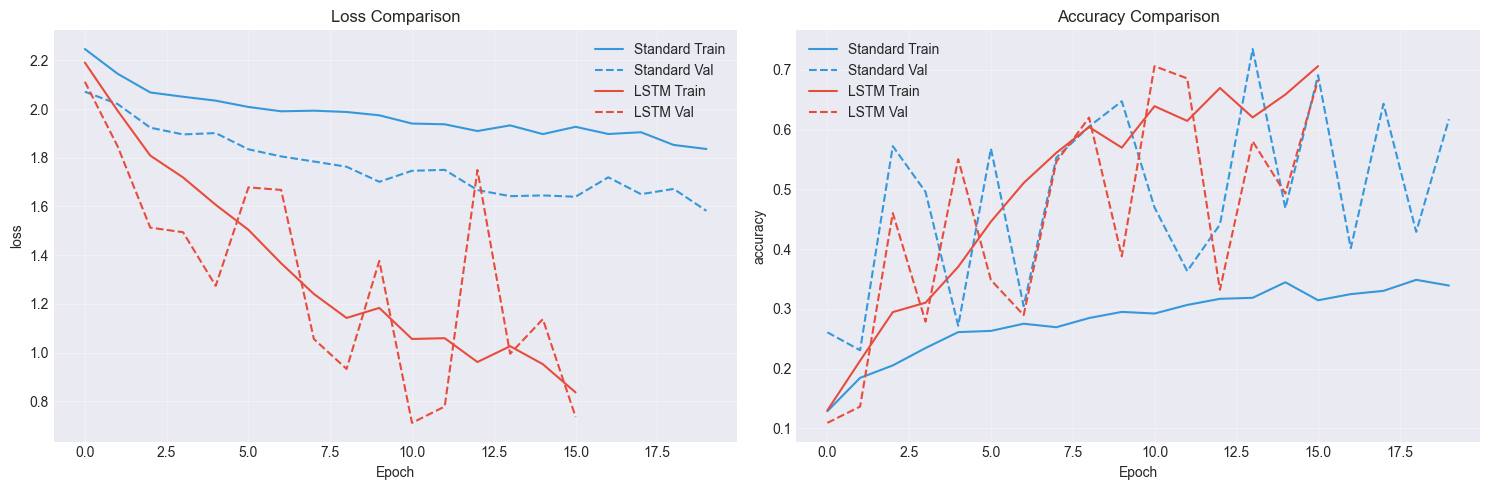

23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 758ms/step


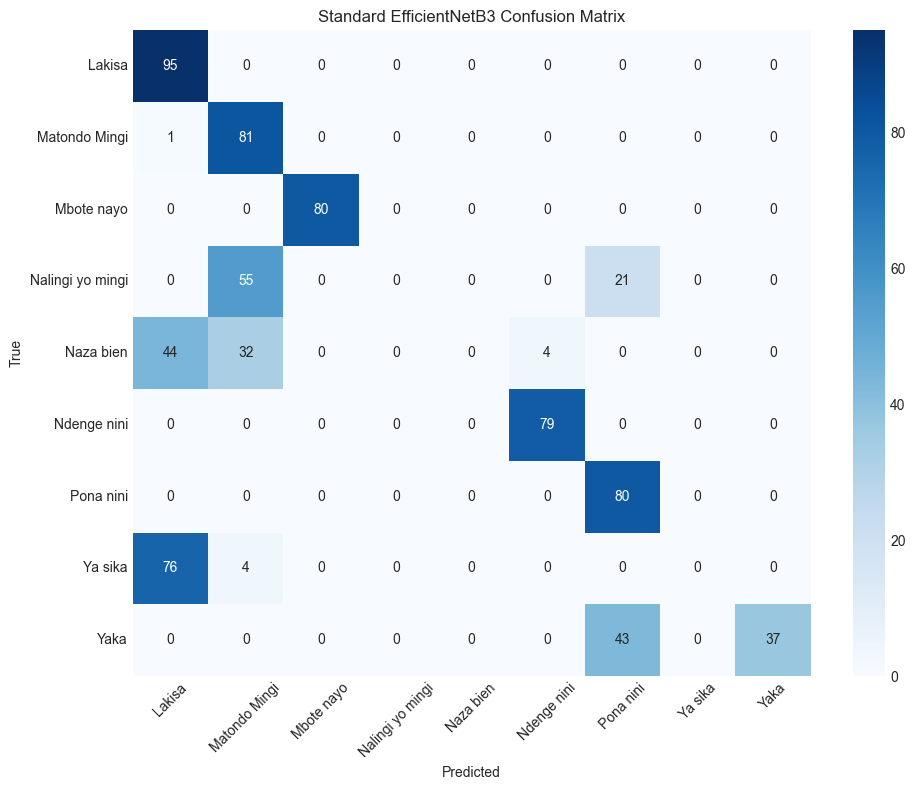

d:\projets\envp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projets\envp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projets\envp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

          Lakisa       0.44      1.00      0.61        95
   Matondo Mingi       0.47      0.99      0.64        82
      Mbote nayo       1.00      1.00      1.00        80
Nalingi yo mingi       0.00      0.00      0.00        76
       Naza bien       0.00      0.00      0.00        80
     Ndenge nini       0.95      1.00      0.98        79
       Pona nini       0.56      1.00      0.71        80
         Ya sika       0.00      0.00      0.00        80
            Yaka       1.00      0.46      0.63        80

        accuracy                           0.62       732
       macro avg       0.49      0.61      0.51       732
    weighted avg       0.49      0.62      0.51       732

23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 816ms/step


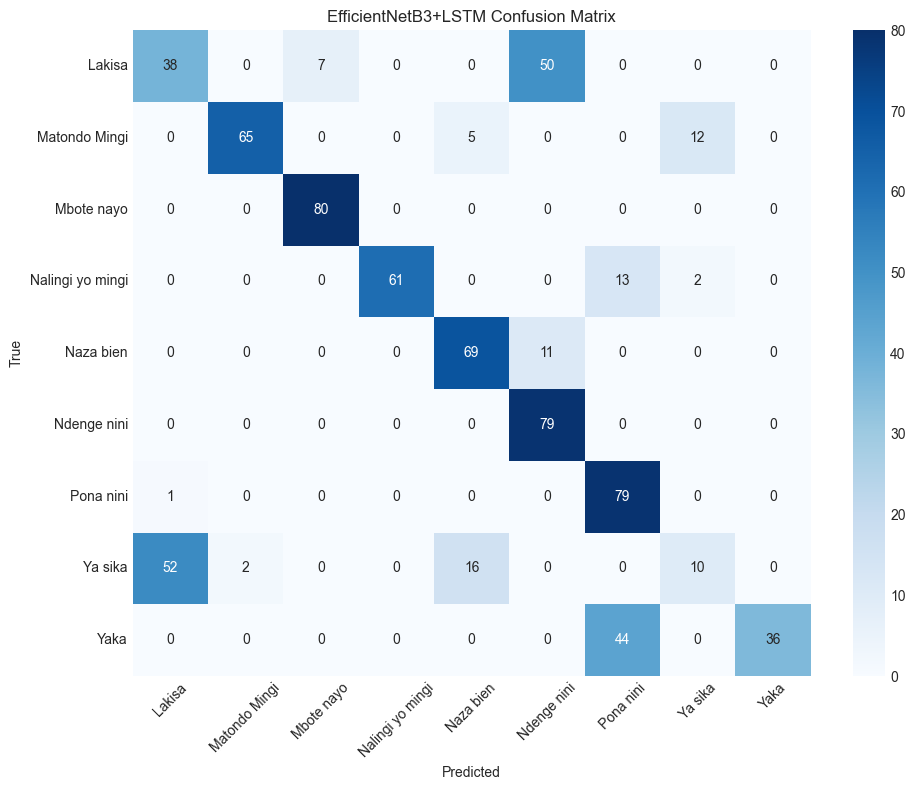

                  precision    recall  f1-score   support

          Lakisa       0.42      0.40      0.41        95
   Matondo Mingi       0.97      0.79      0.87        82
      Mbote nayo       0.92      1.00      0.96        80
Nalingi yo mingi       1.00      0.80      0.89        76
       Naza bien       0.77      0.86      0.81        80
     Ndenge nini       0.56      1.00      0.72        79
       Pona nini       0.58      0.99      0.73        80
         Ya sika       0.42      0.12      0.19        80
            Yaka       1.00      0.45      0.62        80

        accuracy                           0.71       732
       macro avg       0.74      0.71      0.69       732
    weighted avg       0.73      0.71      0.68       732


=== FINAL RESULTS ===
Model                          Accuracy   Training Time  
-------------------------------------------------------
Standard EfficientNetB3        0.6175      1524.63s
EfficientNetB3 + LSTM          0.7063      1271.86s

R

In [ ]:
# Import required libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, LSTM, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Configure device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')
colors = {
    'model1': '#3498db',  # Blue for standard model
    'model2': '#e74c3c'   # Red for LSTM model
}


# === Data Loading Section === 
print("Loading data...")
data_path = r'D:\projets\Data_TeachSign'  # Raw string for Windows path

try:
    # Verify folder exists
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Folder not found: {data_path}")
    
    # Verify all required files exist
    required_files = ['X_train.npy', 'y_train.npy', 
                    'X_val.npy', 'y_val.npy', 
                    'labels.npy']
    
    missing_files = [f for f in required_files 
                   if not os.path.exists(os.path.join(data_path, f))]
    
    if missing_files:
        raise FileNotFoundError(f"Missing files: {missing_files}")
    
    # Load all files
    X_train = np.load(os.path.join(data_path, 'X_train.npy'))
    y_train = np.load(os.path.join(data_path, 'y_train.npy')) 
    X_val = np.load(os.path.join(data_path, 'X_val.npy'))
    y_val = np.load(os.path.join(data_path, 'y_val.npy'))
    label_classes = np.load(os.path.join(data_path, 'labels.npy'))

     # Define input shape from loaded data
    input_shape = X_train.shape[1:]  # This extracts (224, 224, 3)
    num_classes = len(label_classes)
    
    # Success message
    print(f"SUCCESS: Loaded data from {data_path}")
    print(f"X_train shape: {X_train.shape}")
    print(f"Classes: {label_classes}")

except Exception as e:
    print("\nERROR LOADING DATA:")
    print(str(e))
    
    # Diagnostic information
    print("\nFOLDER CONTENTS:")
    if os.path.exists(data_path):
        for i, f in enumerate(os.listdir(data_path)):
            print(f"{i+1}. {f}")
    else:
        print(f"Folder does not exist: {data_path}")
    
    # Suggested fixes
    print("\nPOSSIBLE SOLUTIONS:")
    print("1. Verify the path is correct:")
    print(f"   Current path: {os.path.abspath(data_path)}")
    print("2. Check all required files exist in the folder")
    print("3. Try copying the folder to:")
    print(f"   {os.path.join(os.getcwd(), 'Data_TeachSign')}")
    
    raise SystemExit("Cannot continue without data")

# Rest of your model code continues here...

# === Model Configuration ===
batch_size = 64
epochs = 20
learning_rate = 0.003
num_classes = len(label_classes)

def create_standard_model():
    """Create standard EfficientNetB3 model with frozen base"""
    base_model = EfficientNetB3(weights='imagenet', 
                              include_top=False, 
                              input_shape=input_shape)
    base_model.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def create_lstm_model():
    """Create hybrid EfficientNetB3 + LSTM model"""
    base_model = EfficientNetB3(weights='imagenet',
                              include_top=False,
                              input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, -1))(x)  # Add temporal dimension
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(128)(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# === Model Training ===
def train_model(model, X, y, X_val, y_val, model_name):
    """Train model with callbacks and save results"""
    print(f"\n=== Training {model_name} ===")
    model.summary()
    
    checkpoint_path = os.path.join(data_path, f'{model_name}_best_model.h5')
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint(checkpoint_path, 
                      save_best_only=True,
                      monitor='val_accuracy',
                      mode='max')
    ]
    
    start_time = time.time()
    history = model.fit(
        X, y,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=callbacks
    )
    training_time = time.time() - start_time
    
    # Save final model
    model.save(os.path.join(data_path, f'{model_name}_final_model.h5'))
    print(f"{model_name} training complete in {training_time:.2f}s")
    
    return history, training_time

# Train both models
model1 = create_standard_model()
history1, time1 = train_model(model1, X_train, y_train, X_val, y_val, 
                             'efficientnetb3_standard')

model2 = create_lstm_model()
history2, time2 = train_model(model2, X_train, y_train, X_val, y_val,
                            'efficientnetb3_lstm')

# === Evaluation ===
def evaluate_model(model, X, y, model_name):
    """Evaluate model and return metrics"""
    loss, acc = model.evaluate(X, y, verbose=0)
    print(f"\n{model_name} Evaluation:")
    print(f"- Accuracy: {acc:.4f}")
    print(f"- Loss: {loss:.4f}")
    return loss, acc

val_loss1, val_acc1 = evaluate_model(model1, X_val, y_val, "Standard EfficientNetB3")
val_loss2, val_acc2 = evaluate_model(model2, X_val, y_val, "EfficientNetB3 + LSTM")

# Calculate improvement
acc_improvement = ((val_acc2 - val_acc1) / val_acc1) * 100

# === Visualization ===
def plot_comparison(history1, history2, metrics):
    """Plot training comparison for two models"""
    plt.figure(figsize=(15, 5))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i+1)
        plt.plot(history1.history[metric], color=colors['model1'], 
                label='Standard Train')
        plt.plot(history1.history[f'val_{metric}'], color=colors['model1'], 
                linestyle='--', label='Standard Val')
        plt.plot(history2.history[metric], color=colors['model2'],
                label='LSTM Train')
        plt.plot(history2.history[f'val_{metric}'], color=colors['model2'],
                linestyle='--', label='LSTM Val')
        plt.title(f'{metric.capitalize()} Comparison')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(data_path, 'training_comparison.png'))
    plt.show()

plot_comparison(history1, history2, ['loss', 'accuracy'])

# === Confusion Matrix ===
def plot_confusion_matrix(model, X, y, classes, title):
    """Generate and plot confusion matrix"""
    y_pred = np.argmax(model.predict(X), axis=1)
    cm = confusion_matrix(y, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=classes,
               yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print(classification_report(y, y_pred, target_names=classes))

plot_confusion_matrix(model1, X_val, y_val, label_classes,
                    "Standard EfficientNetB3 Confusion Matrix")

plot_confusion_matrix(model2, X_val, y_val, label_classes,
                    "EfficientNetB3+LSTM Confusion Matrix")

# === Final Report ===
print("\n=== FINAL RESULTS ===")
print(f"{'Model':<30} {'Accuracy':<10} {'Training Time':<15}")
print("-" * 55)
print(f"{'Standard EfficientNetB3':<30} {val_acc1:.4f}{'':<5} {time1:.2f}s")
print(f"{'EfficientNetB3 + LSTM':<30} {val_acc2:.4f}{'':<5} {time2:.2f}s")
print(f"\nRelative Accuracy Improvement: {acc_improvement:.2f}%")

# Recommendation
best_model = "EfficientNetB3 + LSTM" if val_acc2 > val_acc1 else "Standard EfficientNetB3"
print(f"\nRECOMMENDATION: Use {best_model} for deployment")

Loading data...
SUCCESS: Loaded data from D:\projets\Data_TeachSign
X_train shape: (2925, 224, 224, 3)
Number of classes: 9
Classes: ['Lakisa' 'Matondo Mingi' 'Mbote nayo' 'Nalingi yo mingi' 'Naza bien'
 'Ndenge nini' 'Pona nini' 'Ya sika' 'Yaka']

=== Model 1: Standard EfficientNetB3 ===


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_12        │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_6     │ (None, 224, 224,  │          7 │ rescaling_12[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_13        │ (None, 224, 224,  │          0 │ normalization_6[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_13[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,797,368 (41.19 MB)

 Trainable params: 13,833 (54.04 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.1151 - loss: 2.2436

92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 899ms/step - accuracy: 0.1151 - loss: 2.2435 - val_accuracy: 0.1298 - val_loss: 2.1889
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 919ms/step - accuracy: 0.1236 - loss: 2.2226 - val_accuracy: 0.1298 - val_loss: 2.1809
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 894ms/step - accuracy: 0.1388 - loss: 2.2140 - val_accuracy: 0.1298 - val_loss: 2.1715
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 900ms/step - accuracy: 0.1362 - loss: 2.2019 - val_accuracy: 0.1298 - val_loss: 2.1629
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 900ms/step - accuracy: 0.1362 - loss: 2.2018 - val_accuracy: 0.1298 - val_loss: 2.1544
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 725ms/step - accuracy: 0.1417 - loss: 2.1875

92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 908ms/step - accuracy: 0.1417 - loss: 2.1876 - val_accuracy: 0.2363 - val_loss: 2.1465
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 902ms/step - accuracy: 0.1300 - loss: 2.1992 - val_accuracy: 0.1352 - val_loss: 2.1387
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 904ms/step - accuracy: 0.1166 - loss: 2.1995 - val_accuracy: 0.1298 - val_loss: 2.1315
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 899ms/step - accuracy: 0.1487 - loss: 2.1720 - val_accuracy: 0.1352 - val_loss: 2.1263
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 862ms/step - accuracy: 0.1499 - loss: 2.1811

92/92 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.1499 - loss: 2.1810 - val_accuracy: 0.3347 - val_loss: 2.1194
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 892ms/step - accuracy: 0.1560 - loss: 2.1565 - val_accuracy: 0.3074 - val_loss: 2.1111
Epoch 12/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 892ms/step - accuracy: 0.1620 - loss: 2.1521 - val_accuracy: 0.1298 - val_loss: 2.1043
Epoch 13/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 886ms/step - accuracy: 0.1528 - loss: 2.1585 - val_accuracy: 0.2937 - val_loss: 2.0990
Epoch 14/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 718ms/step - accuracy: 0.1665 - loss: 2.1538

92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 896ms/step - accuracy: 0.1665 - loss: 2.1537 - val_accuracy: 0.4153 - val_loss: 2.0915
Epoch 15/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 884ms/step - accuracy: 0.1824 - loss: 2.1468 - val_accuracy: 0.2623 - val_loss: 2.0852
Epoch 16/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 0.1613 - loss: 2.1479

92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 891ms/step - accuracy: 0.1614 - loss: 2.1479 - val_accuracy: 0.4167 - val_loss: 2.0792
Epoch 17/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 899ms/step - accuracy: 0.1738 - loss: 2.1377 - val_accuracy: 0.3634 - val_loss: 2.0723
Epoch 18/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 902ms/step - accuracy: 0.1636 - loss: 2.1428 - val_accuracy: 0.3702 - val_loss: 2.0671
Epoch 19/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.1836 - loss: 2.1245

92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 902ms/step - accuracy: 0.1837 - loss: 2.1244 - val_accuracy: 0.4932 - val_loss: 2.0610
Epoch 20/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.1817 - loss: 2.1260

92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 891ms/step - accuracy: 0.1816 - loss: 2.1260 - val_accuracy: 0.6585 - val_loss: 2.0560
Epoch 21/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 889ms/step - accuracy: 0.1896 - loss: 2.1207 - val_accuracy: 0.3921 - val_loss: 2.0503
Epoch 22/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 893ms/step - accuracy: 0.1885 - loss: 2.1152 - val_accuracy: 0.4167 - val_loss: 2.0454
Epoch 23/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 902ms/step - accuracy: 0.1920 - loss: 2.1066 - val_accuracy: 0.2719 - val_loss: 2.0422
Epoch 24/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 887ms/step - accuracy: 0.1942 - loss: 2.1108 - val_accuracy: 0.4098 - val_loss: 2.0357
Epoch 25/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 887ms/step - accuracy: 0.2104 - loss: 2.1067 - val_accuracy: 0.3620 - val_loss: 2.0315
Epoch 26/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 897ms/step - accuracy: 0.2036 - loss: 2.1011 - val_accuracy: 0.2500 - val_loss: 2.0267
Epoch 27/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 893ms/step - accuracy: 0.2082 - loss: 2.0820 - val_accuracy

92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 892ms/step - accuracy: 0.2305 - loss: 2.0581 - val_accuracy: 0.7172 - val_loss: 1.9820
Epoch 37/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 874ms/step - accuracy: 0.2269 - loss: 2.0559 - val_accuracy: 0.5232 - val_loss: 1.9778
Epoch 38/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 877ms/step - accuracy: 0.2388 - loss: 2.0529 - val_accuracy: 0.4290 - val_loss: 1.9732
Epoch 39/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 883ms/step - accuracy: 0.2362 - loss: 2.0647 - val_accuracy: 0.4440 - val_loss: 1.9705
Epoch 40/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 881ms/step - accuracy: 0.2475 - loss: 2.0579 - val_accuracy: 0.5164 - val_loss: 1.9652
Epoch 41/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 876ms/step - accuracy: 0.2473 - loss: 2.0606 - val_accuracy: 0.4098 - val_loss: 1.9635
Epoch 42/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 877ms/step - accuracy: 0.2379 - loss: 2.0674 - val_accuracy: 0.5205 - val_loss: 1.9600
Epoch 43/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 867ms/step - accuracy: 0.2390 - loss: 2.0691 - val_accuracy

Standard model training time: 4117.12 seconds

=== Model 2: EfficientNetB3 + LSTM ===


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_14        │ (None, 224, 224,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_7     │ (None, 224, 224,  │          7 │ rescaling_14[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_15        │ (None, 224, 224,  │          0 │ normalization_7[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_15[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 12,817,848 (48.90 MB)

 Trainable params: 2,034,313 (7.76 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.1288 - loss: 2.1962

92/92 ━━━━━━━━━━━━━━━━━━━━ 107s 997ms/step - accuracy: 0.1288 - loss: 2.1962 - val_accuracy: 0.1298 - val_loss: 2.1884
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 911ms/step - accuracy: 0.1365 - loss: 2.1871 - val_accuracy: 0.1298 - val_loss: 2.1690
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.1573 - loss: 2.1655

92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 913ms/step - accuracy: 0.1575 - loss: 2.1654 - val_accuracy: 0.2322 - val_loss: 2.1037
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.1936 - loss: 2.1194

92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 918ms/step - accuracy: 0.1936 - loss: 2.1192 - val_accuracy: 0.4495 - val_loss: 1.9990
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 920ms/step - accuracy: 0.2202 - loss: 2.0359 - val_accuracy: 0.2705 - val_loss: 1.8792
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 922ms/step - accuracy: 0.2598 - loss: 1.9525 - val_accuracy: 0.2199 - val_loss: 1.8110
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 910ms/step - accuracy: 0.2832 - loss: 1.9075 - val_accuracy: 0.2022 - val_loss: 1.8063
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 918ms/step - accuracy: 0.3316 - loss: 1.8293 - val_accuracy: 0.2514 - val_loss: 1.7059
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 922ms/step - accuracy: 0.3430 - loss: 1.7879 - val_accuracy: 0.2036 - val_loss: 1.7524
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 920ms/step - accuracy: 0.3700 - loss: 1.7377 - val_accuracy: 0.3989 - val_loss: 1.5977
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 922ms/step - accuracy: 0.3969 - loss: 1.7154 - val_accuracy: 0.3

92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 929ms/step - accuracy: 0.4430 - loss: 1.6061 - val_accuracy: 0.4686 - val_loss: 1.4188
Epoch 14/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 910ms/step - accuracy: 0.4466 - loss: 1.5795 - val_accuracy: 0.4249 - val_loss: 1.4944
Epoch 15/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.4692 - loss: 1.5294

92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 918ms/step - accuracy: 0.4693 - loss: 1.5294 - val_accuracy: 0.5027 - val_loss: 1.3688
Epoch 16/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.5170 - loss: 1.5142

92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 919ms/step - accuracy: 0.5171 - loss: 1.5138 - val_accuracy: 0.6066 - val_loss: 1.2109
Epoch 17/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 924ms/step - accuracy: 0.4994 - loss: 1.4866 - val_accuracy: 0.5710 - val_loss: 1.2473
Epoch 18/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.5422 - loss: 1.3908

92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 933ms/step - accuracy: 0.5422 - loss: 1.3907 - val_accuracy: 0.6803 - val_loss: 1.1088
Epoch 19/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 913ms/step - accuracy: 0.5651 - loss: 1.3713 - val_accuracy: 0.4604 - val_loss: 1.3038
Epoch 20/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 920ms/step - accuracy: 0.5694 - loss: 1.3535 - val_accuracy: 0.4822 - val_loss: 1.2022
Epoch 21/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 913ms/step - accuracy: 0.5560 - loss: 1.2886 - val_accuracy: 0.5109 - val_loss: 1.1350
Epoch 22/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.5737 - loss: 1.2705

92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 917ms/step - accuracy: 0.5738 - loss: 1.2705 - val_accuracy: 0.8156 - val_loss: 0.9289
Epoch 23/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 896ms/step - accuracy: 0.6050 - loss: 1.2302 - val_accuracy: 0.5273 - val_loss: 1.1359
Epoch 24/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 901ms/step - accuracy: 0.5933 - loss: 1.2315 - val_accuracy: 0.6407 - val_loss: 0.9639
Epoch 25/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 897ms/step - accuracy: 0.5992 - loss: 1.2182 - val_accuracy: 0.6776 - val_loss: 0.9150
Epoch 26/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 901ms/step - accuracy: 0.5946 - loss: 1.2004 - val_accuracy: 0.6216 - val_loss: 0.9869
Epoch 27/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 909ms/step - accuracy: 0.6342 - loss: 1.1230 - val_accuracy: 0.6831 - val_loss: 0.8710
Epoch 28/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 902ms/step - accuracy: 0.6251 - loss: 1.1396 - val_accuracy: 0.7158 - val_loss: 0.8151
Epoch 29/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 900ms/step - accuracy: 0.6306 - loss: 1.1500 - val_accuracy

LSTM model training time: 3354.29 seconds

=== Model evaluation ===
Standard EfficientNetB3 Model:
  - Validation accuracy: 0.6120
  - Validation loss: 1.9335
  - Training time: 4117.12 seconds

EfficientNetB3 + LSTM Model:
  - Validation accuracy: 0.7432
  - Validation loss: 0.7253
  - Training time: 3354.29 seconds

Relative accuracy improvement with LSTM: 21.43%


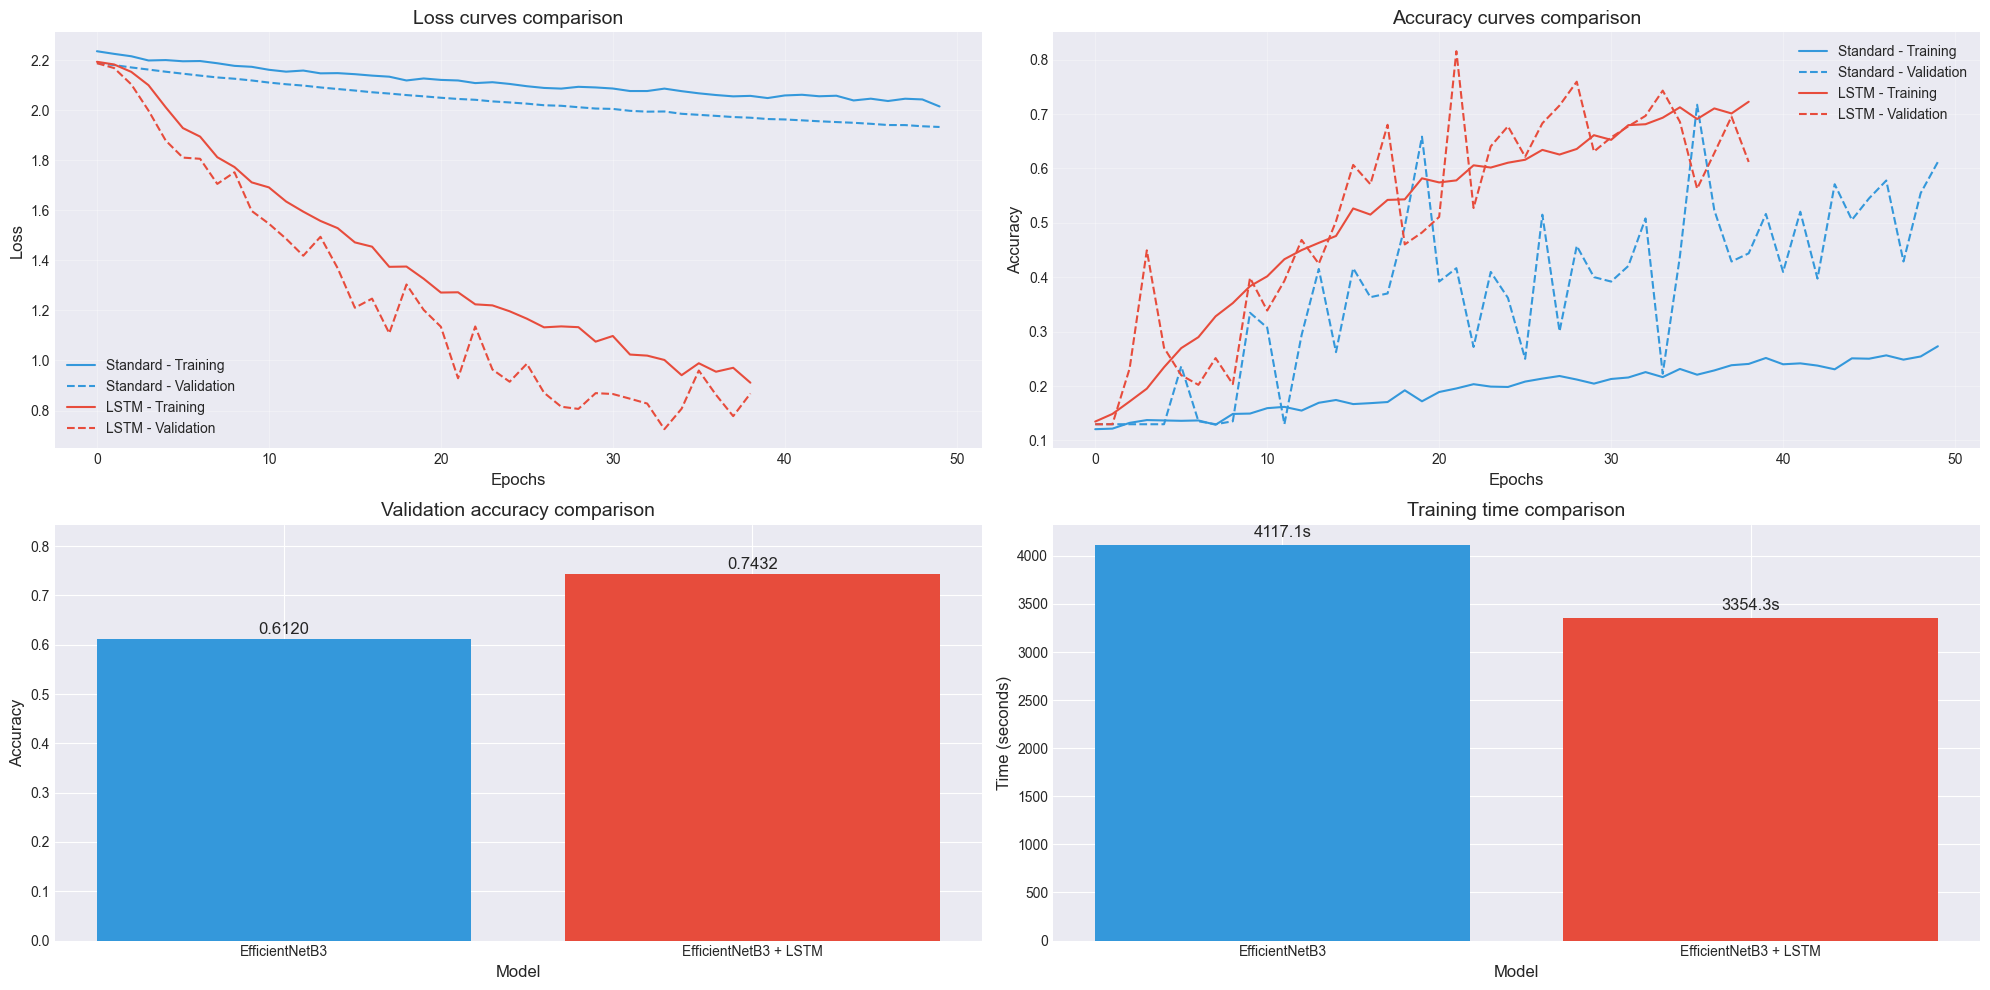

23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 812ms/step


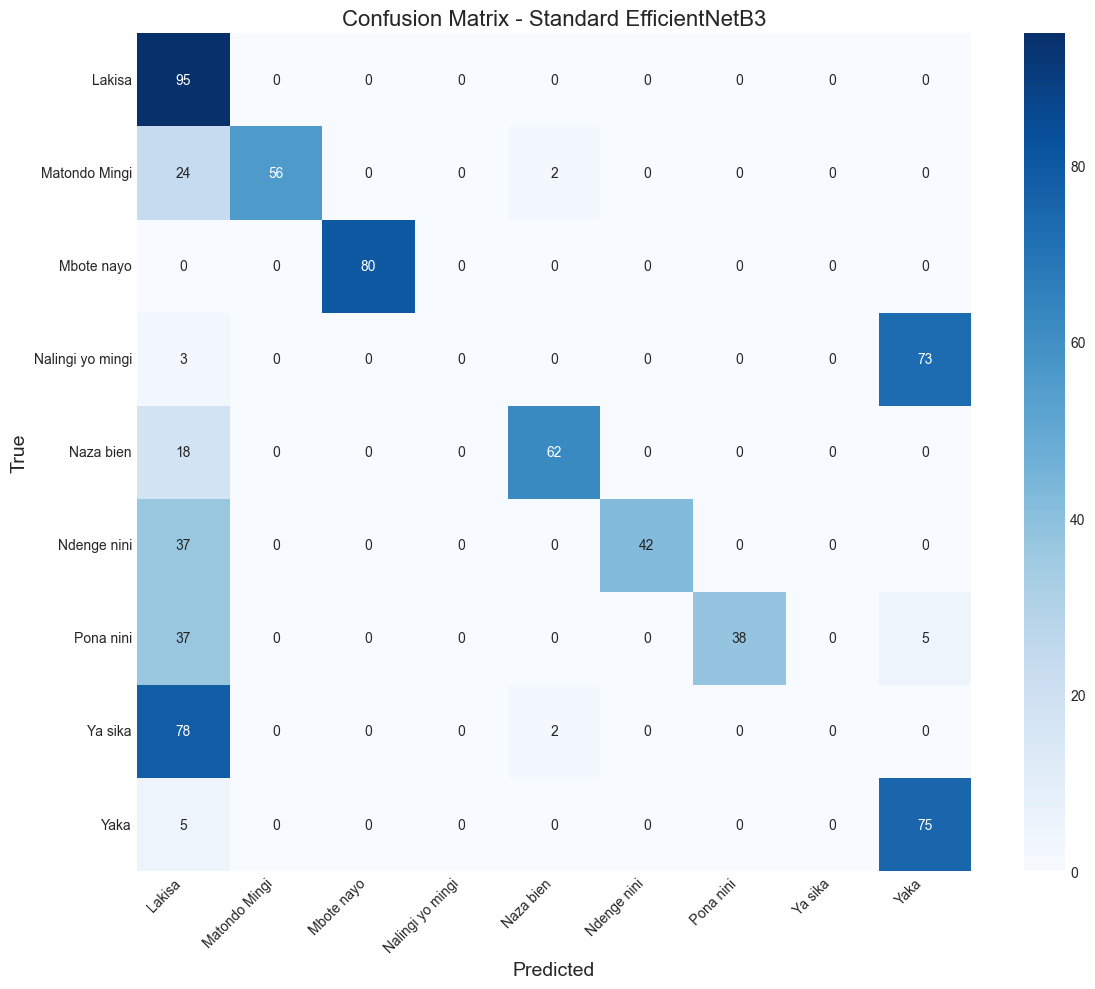


Classification report for Confusion Matrix - Standard EfficientNetB3:
                  precision    recall  f1-score   support

          Lakisa       0.32      1.00      0.48        95
   Matondo Mingi       1.00      0.68      0.81        82
      Mbote nayo       1.00      1.00      1.00        80
Nalingi yo mingi       0.00      0.00      0.00        76
       Naza bien       0.94      0.78      0.85        80
     Ndenge nini       1.00      0.53      0.69        79
       Pona nini       1.00      0.47      0.64        80
         Ya sika       0.00      0.00      0.00        80
            Yaka       0.49      0.94      0.64        80

        accuracy                           0.61       732
       macro avg       0.64      0.60      0.57       732
    weighted avg       0.64      0.61      0.57       732



d:\projets\envp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projets\envp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projets\envp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 822ms/step


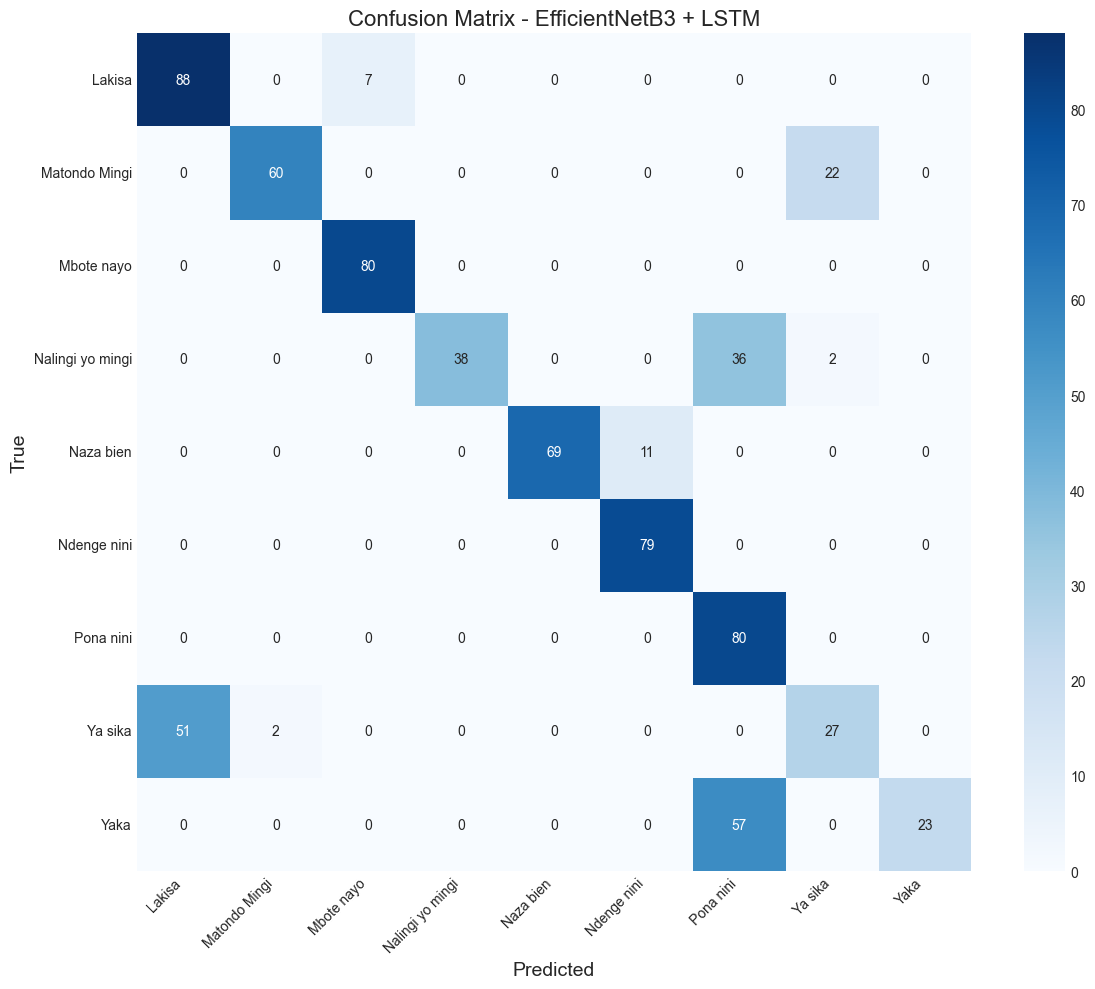


Classification report for Confusion Matrix - EfficientNetB3 + LSTM:
                  precision    recall  f1-score   support

          Lakisa       0.63      0.93      0.75        95
   Matondo Mingi       0.97      0.73      0.83        82
      Mbote nayo       0.92      1.00      0.96        80
Nalingi yo mingi       1.00      0.50      0.67        76
       Naza bien       1.00      0.86      0.93        80
     Ndenge nini       0.88      1.00      0.93        79
       Pona nini       0.46      1.00      0.63        80
         Ya sika       0.53      0.34      0.41        80
            Yaka       1.00      0.29      0.45        80

        accuracy                           0.74       732
       macro avg       0.82      0.74      0.73       732
    weighted avg       0.82      0.74      0.73       732


===== RESULTS SUMMARY =====
Metric                    EfficientNetB3       EfficientNetB3 + LSTM Difference     
------------------------------------------------------------

In [5]:
# Install required libraries (run once)
# !pip install tensorflow matplotlib numpy scikit-learn seaborn

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, LSTM, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch


# Configure device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')
colors = {
    'model1': '#3498db',  # Blue for standard model
    'model2': '#e74c3c'   # Red for LSTM model
}

# === Data Loading Section === 
print("Loading data...")
data_path = r'D:\projets\Data_TeachSign'  # Raw string for Windows path

try:
    # Verify folder exists
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Folder not found: {data_path}")
    
    # Verify all required files exist
    required_files = ['X_train.npy', 'y_train.npy', 
                     'X_val.npy', 'y_val.npy', 
                     'labels.npy']
    
    missing_files = [f for f in required_files 
                   if not os.path.exists(os.path.join(data_path, f))]
    
    if missing_files:
        raise FileNotFoundError(f"Missing files: {missing_files}")
    
    # Load all files
    X_train = np.load(os.path.join(data_path, 'X_train.npy'))
    y_train = np.load(os.path.join(data_path, 'y_train.npy')) 
    X_val = np.load(os.path.join(data_path, 'X_val.npy'))
    y_val = np.load(os.path.join(data_path, 'y_val.npy'))
    label_classes = np.load(os.path.join(data_path, 'labels.npy'))

    # Define input shape and number of classes from loaded data
    input_shape = X_train.shape[1:]  # Extracts (224, 224, 3)
    num_classes = len(label_classes)
    
    # Success message
    print(f"SUCCESS: Loaded data from {data_path}")
    print(f"X_train shape: {X_train.shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {label_classes}")

except Exception as e:
    print("\nERROR LOADING DATA:")
    print(str(e))
    
    # Diagnostic information
    print("\nFOLDER CONTENTS:")
    if os.path.exists(data_path):
        for i, f in enumerate(os.listdir(data_path)):
            print(f"{i+1}. {f}")
    else:
        print(f"Folder does not exist: {data_path}")
    
    # Suggested fixes
    print("\nPOSSIBLE SOLUTIONS:")
    print("1. Verify the path is correct:")
    print(f"   Current path: {os.path.abspath(data_path)}")
    print("2. Check all required files exist in the folder")
    print("3. Try copying the folder to:")
    print(f"   {os.path.join(os.getcwd(), 'Data_TeachSign')}")
    
    raise SystemExit("Cannot continue without data")

# Training parameters configuration
batch_size = 32
epochs = 50
learning_rate = 0.0001

# Function to create standard EfficientNetB3 model
def create_standard_model():
    """Create standard EfficientNetB3 model with frozen base"""
    base_model = EfficientNetB3(weights='imagenet', 
                              include_top=False, 
                              input_shape=input_shape)
    base_model.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Function to create EfficientNetB3 + LSTM model
def create_lstm_model():
    """Create hybrid EfficientNetB3 + LSTM model"""
    base_model = EfficientNetB3(weights='imagenet',
                              include_top=False,
                              input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add temporal dimension for LSTM (treat as sequence of 1)
    x = Reshape((1, -1))(x)
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(128)(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# === Train standard EfficientNetB3 model ===
print("\n=== Model 1: Standard EfficientNetB3 ===")
model1 = create_standard_model()
model1.summary()

checkpoint_path1 = os.path.join(data_path, 'efficientnetb3_standard_best_model.h5')
callbacks1 = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path1, 
                  save_best_only=True, 
                  monitor='val_accuracy', 
                  mode='max')
]

start_time1 = time.time()
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks1
)
training_time1 = time.time() - start_time1

print(f"Standard model training time: {training_time1:.2f} seconds")
model1.save(os.path.join(data_path, 'efficientnetb3_standard_final_model.h5'))

# === Train EfficientNetB3 + LSTM model ===
print("\n=== Model 2: EfficientNetB3 + LSTM ===")
model2 = create_lstm_model()
model2.summary()

checkpoint_path2 = os.path.join(data_path, 'efficientnetb3_lstm_best_model.h5')
callbacks2 = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path2,
                  save_best_only=True,
                  monitor='val_accuracy',
                  mode='max')
]

start_time2 = time.time()
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks2
)
training_time2 = time.time() - start_time2

print(f"LSTM model training time: {training_time2:.2f} seconds")
model2.save(os.path.join(data_path, 'efficientnetb3_lstm_final_model.h5'))

# === Performance comparison ===
print("\n=== Model evaluation ===")
val_loss1, val_acc1 = model1.evaluate(X_val, y_val, verbose=0)
val_loss2, val_acc2 = model2.evaluate(X_val, y_val, verbose=0)

print(f"Standard EfficientNetB3 Model:")
print(f"  - Validation accuracy: {val_acc1:.4f}")
print(f"  - Validation loss: {val_loss1:.4f}")
print(f"  - Training time: {training_time1:.2f} seconds")

print(f"\nEfficientNetB3 + LSTM Model:")
print(f"  - Validation accuracy: {val_acc2:.4f}")
print(f"  - Validation loss: {val_loss2:.4f}")
print(f"  - Training time: {training_time2:.2f} seconds")

# Relative improvement in percentage
acc_improvement = ((val_acc2 - val_acc1) / val_acc1) * 100
print(f"\nRelative accuracy improvement with LSTM: {acc_improvement:.2f}%")

# === Comparison plots ===
plt.figure(figsize=(20, 10))

# Loss curve
plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'], color=colors['model1'], linestyle='-', label='Standard - Training')
plt.plot(history1.history['val_loss'], color=colors['model1'], linestyle='--', label='Standard - Validation')
plt.plot(history2.history['loss'], color=colors['model2'], linestyle='-', label='LSTM - Training')
plt.plot(history2.history['val_loss'], color=colors['model2'], linestyle='--', label='LSTM - Validation')
plt.title('Loss curves comparison', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Accuracy curve
plt.subplot(2, 2, 2)
plt.plot(history1.history['accuracy'], color=colors['model1'], linestyle='-', label='Standard - Training')
plt.plot(history1.history['val_accuracy'], color=colors['model1'], linestyle='--', label='Standard - Validation')
plt.plot(history2.history['accuracy'], color=colors['model2'], linestyle='-', label='LSTM - Training')
plt.plot(history2.history['val_accuracy'], color=colors['model2'], linestyle='--', label='LSTM - Validation')
plt.title('Accuracy curves comparison', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Final accuracy (bar plot)
plt.subplot(2, 2, 3)
models = ['EfficientNetB3', 'EfficientNetB3 + LSTM']
accuracies = [val_acc1, val_acc2]
plt.bar(models, accuracies, color=[colors['model1'], colors['model2']])
plt.title('Validation accuracy comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=12)
plt.ylim(0, max(accuracies) + 0.1)

# Training time (bar plot)
plt.subplot(2, 2, 4)
times = [training_time1, training_time2]
plt.bar(models, times, color=[colors['model1'], colors['model2']])
plt.title('Training time comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
for i, v in enumerate(times):
    plt.text(i, v + max(times)*0.02, f'{v:.1f}s', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(data_path, 'model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# === Confusion matrices ===
def plot_confusion_matrix(model, X, y, title, save_path=None):
    """Generate and plot confusion matrix"""
    y_pred = np.argmax(model.predict(X), axis=1)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=label_classes,
               yticklabels=label_classes)
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    print(f"\nClassification report for {title}:")
    print(classification_report(y, y_pred, target_names=label_classes))

# Plot confusion matrices
plot_confusion_matrix(model1, X_val, y_val,
                    "Confusion Matrix - Standard EfficientNetB3",
                    os.path.join(data_path, 'confusion_standard.png'))

plot_confusion_matrix(model2, X_val, y_val,
                    "Confusion Matrix - EfficientNetB3 + LSTM",
                    os.path.join(data_path, 'confusion_lstm.png'))

# === Results summary ===
print("\n===== RESULTS SUMMARY =====")
print(f"{'Metric':<25} {'EfficientNetB3':<20} {'EfficientNetB3 + LSTM':<20} {'Difference':<15}")
print("-" * 80)
print(f"{'Validation accuracy':<25} {val_acc1:.4f}{'':<15} {val_acc2:.4f}{'':<15} {val_acc2-val_acc1:+.4f}")
print(f"{'Validation loss':<25} {val_loss1:.4f}{'':<15} {val_loss2:.4f}{'':<15} {val_loss2-val_loss1:+.4f}")
print(f"{'Training time (s)':<25} {training_time1:.2f}{'':<15} {training_time2:.2f}{'':<15} {training_time2-training_time1:+.2f}")
print(f"{'Relative improvement':<25} {'N/A':<20} {acc_improvement:+.2f}%{'':<12}")
print("-" * 80)

# Detect best model
best_model = "EfficientNetB3 + LSTM" if val_acc2 > val_acc1 else "Standard EfficientNetB3"
print(f"\nBest model: {best_model}")

# Conclusion
print("\nCONCLUSION:")
if val_acc2 > val_acc1:
    print(f"Adding LSTM layers improved accuracy by {acc_improvement:.2f}%, " +
         f"with validation accuracy of {val_acc2:.4f} vs {val_acc1:.4f} for the standard model.")
    if training_time2 > training_time1:
        print(f"However, this improvement comes with a training time increase " +
             f"of {training_time2-training_time1:.2f} seconds ({(training_time2/training_time1-1)*100:.1f}% longer).")
else:
    print(f"The standard EfficientNetB3 model performed better with an accuracy of " +
         f"{val_acc1:.4f} vs {val_acc2:.4f} for the LSTM model.")
    print(f"Moreover, the standard model is faster to train by {abs(training_time2-training_time1):.2f} seconds.")

print("\nRecommendation for the Lingala Sign Language Translation System:")
if val_acc2 > val_acc1 and (training_time2 - training_time1) / training_time1 < 0.5:
    print("Use the EfficientNetB3 + LSTM model for better accuracy with a reasonable trade-off on training time.")
elif val_acc2 > val_acc1:
    print("Evaluate the trade-off between the LSTM model's increased accuracy and its longer training time.")
else:
    print("Prefer the standard EfficientNetB3 model for its good balance between accuracy and training efficiency.")

Loading data...
SUCCESS: Loaded data from D:\projets\Data_TeachSign
X_train shape: (2925, 224, 224, 3)
Number of classes: 9
Classes: ['Lakisa' 'Matondo Mingi' 'Mbote nayo' 'Nalingi yo mingi' 'Naza bien'
 'Ndenge nini' 'Pona nini' 'Ya sika' 'Yaka']

=== Model 1: Standard EfficientNetB3 ===


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_16        │ (None, 224, 224,  │          0 │ input_layer_8[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_8     │ (None, 224, 224,  │          7 │ rescaling_16[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_17        │ (None, 224, 224,  │          0 │ normalization_8[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_17[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 10,797,368 (41.19 MB)

 Trainable params: 13,833 (54.04 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.1137 - loss: 2.2281

92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 961ms/step - accuracy: 0.1137 - loss: 2.2282 - val_accuracy: 0.1995 - val_loss: 2.1857
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 901ms/step - accuracy: 0.1203 - loss: 2.2294 - val_accuracy: 0.1298 - val_loss: 2.1768
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 917ms/step - accuracy: 0.1340 - loss: 2.2172 - val_accuracy: 0.1298 - val_loss: 2.1675
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.1370 - loss: 2.2019 - val_accuracy: 0.1298 - val_loss: 2.1606
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.1351 - loss: 2.1948

92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 906ms/step - accuracy: 0.1351 - loss: 2.1948 - val_accuracy: 0.3019 - val_loss: 2.1503
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.1422 - loss: 2.1927

92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 922ms/step - accuracy: 0.1421 - loss: 2.1927 - val_accuracy: 0.3470 - val_loss: 2.1420
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 919ms/step - accuracy: 0.1420 - loss: 2.1861 - val_accuracy: 0.1366 - val_loss: 2.1343
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 921ms/step - accuracy: 0.1373 - loss: 2.1798 - val_accuracy: 0.1298 - val_loss: 2.1264
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 920ms/step - accuracy: 0.1571 - loss: 2.1740 - val_accuracy: 0.1352 - val_loss: 2.1204
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.1548 - loss: 2.1692

92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 923ms/step - accuracy: 0.1547 - loss: 2.1693 - val_accuracy: 0.3893 - val_loss: 2.1121
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.1697 - loss: 2.1563

92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 928ms/step - accuracy: 0.1697 - loss: 2.1563 - val_accuracy: 0.4904 - val_loss: 2.1045
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.1562 - loss: 2.1660

92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 936ms/step - accuracy: 0.1563 - loss: 2.1660 - val_accuracy: 0.5546 - val_loss: 2.0984
Epoch 13/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 927ms/step - accuracy: 0.1511 - loss: 2.1588 - val_accuracy: 0.4617 - val_loss: 2.0927
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 944ms/step - accuracy: 0.1730 - loss: 2.1426 - val_accuracy: 0.2363 - val_loss: 2.0854
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 925ms/step - accuracy: 0.1816 - loss: 2.1330 - val_accuracy: 0.4372 - val_loss: 2.0788
Epoch 16/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.1917 - loss: 2.1170

92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 931ms/step - accuracy: 0.1916 - loss: 2.1172 - val_accuracy: 0.5574 - val_loss: 2.0720
Epoch 17/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 917ms/step - accuracy: 0.1802 - loss: 2.1260 - val_accuracy: 0.4235 - val_loss: 2.0664
Epoch 18/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 915ms/step - accuracy: 0.1746 - loss: 2.1313 - val_accuracy: 0.3525 - val_loss: 2.0611
Epoch 19/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 919ms/step - accuracy: 0.1804 - loss: 2.1198 - val_accuracy: 0.4016 - val_loss: 2.0547
Epoch 20/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.2037 - loss: 2.1008

92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 921ms/step - accuracy: 0.2036 - loss: 2.1009 - val_accuracy: 0.5792 - val_loss: 2.0490
Epoch 21/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 916ms/step - accuracy: 0.1937 - loss: 2.1142 - val_accuracy: 0.5164 - val_loss: 2.0442
Epoch 22/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 927ms/step - accuracy: 0.2106 - loss: 2.0991 - val_accuracy: 0.4303 - val_loss: 2.0390
Epoch 23/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 922ms/step - accuracy: 0.1909 - loss: 2.1117 - val_accuracy: 0.3784 - val_loss: 2.0337
Epoch 24/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 922ms/step - accuracy: 0.1995 - loss: 2.0873 - val_accuracy: 0.5260 - val_loss: 2.0277
Epoch 25/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.2089 - loss: 2.0987

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 948ms/step - accuracy: 0.2088 - loss: 2.0988 - val_accuracy: 0.6025 - val_loss: 2.0240
Epoch 26/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 938ms/step - accuracy: 0.2040 - loss: 2.1099 - val_accuracy: 0.5410 - val_loss: 2.0192
Epoch 27/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 936ms/step - accuracy: 0.1984 - loss: 2.0870 - val_accuracy: 0.5451 - val_loss: 2.0143
Epoch 28/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 934ms/step - accuracy: 0.2045 - loss: 2.0904 - val_accuracy: 0.5861 - val_loss: 2.0102
Epoch 29/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 925ms/step - accuracy: 0.2132 - loss: 2.0779 - val_accuracy: 0.5464 - val_loss: 2.0061
Epoch 30/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 922ms/step - accuracy: 0.2408 - loss: 2.0714 - val_accuracy: 0.4372 - val_loss: 2.0004
Epoch 31/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 923ms/step - accuracy: 0.2314 - loss: 2.0660 - val_accuracy: 0.4768 - val_loss: 1.9962
Epoch 32/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 897ms/step - accuracy: 0.2466 - loss: 2.0529 - val_a

92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 865ms/step - accuracy: 0.2375 - loss: 2.0572 - val_accuracy: 0.7090 - val_loss: 1.9672
Epoch 39/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 921ms/step - accuracy: 0.2422 - loss: 2.0553 - val_accuracy: 0.4986 - val_loss: 1.9647
Epoch 40/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 914ms/step - accuracy: 0.2400 - loss: 2.0572 - val_accuracy: 0.4932 - val_loss: 1.9603
Epoch 41/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 924ms/step - accuracy: 0.2404 - loss: 2.0377 - val_accuracy: 0.5601 - val_loss: 1.9575
Epoch 42/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 918ms/step - accuracy: 0.2310 - loss: 2.0566 - val_accuracy: 0.4413 - val_loss: 1.9549
Epoch 43/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 916ms/step - accuracy: 0.2610 - loss: 2.0274 - val_accuracy: 0.6079 - val_loss: 1.9519
Epoch 44/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 913ms/step - accuracy: 0.2478 - loss: 2.0446 - val_accuracy: 0.5055 - val_loss: 1.9472
Epoch 45/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 915ms/step - accuracy: 0.2548 - loss: 2.0451 - val_a

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 943ms/step - accuracy: 0.2841 - loss: 1.9914 - val_accuracy: 0.7131 - val_loss: 1.8872
Epoch 65/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.2980 - loss: 1.9917

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 947ms/step - accuracy: 0.2979 - loss: 1.9918 - val_accuracy: 0.8470 - val_loss: 1.8852
Epoch 66/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 934ms/step - accuracy: 0.2747 - loss: 1.9988 - val_accuracy: 0.6967 - val_loss: 1.8832
Epoch 67/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 931ms/step - accuracy: 0.2860 - loss: 2.0105 - val_accuracy: 0.5164 - val_loss: 1.8800
Epoch 68/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 942ms/step - accuracy: 0.2889 - loss: 1.9929 - val_accuracy: 0.6831 - val_loss: 1.8773
Epoch 69/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 931ms/step - accuracy: 0.2655 - loss: 2.0060 - val_accuracy: 0.5833 - val_loss: 1.8753
Epoch 70/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 934ms/step - accuracy: 0.2920 - loss: 1.9753 - val_accuracy: 0.5150 - val_loss: 1.8740
Epoch 71/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 932ms/step - accuracy: 0.2783 - loss: 2.0137 - val_accuracy: 0.6148 - val_loss: 1.8706
Epoch 72/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 929ms/step - accuracy: 0.2891 - loss: 1.9770 - val_a

Standard model training time: 8581.68 seconds

=== Model 2: EfficientNetB3 + LSTM ===


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_18        │ (None, 224, 224,  │          0 │ input_layer_9[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_9     │ (None, 224, 224,  │          7 │ rescaling_18[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_19        │ (None, 224, 224,  │          0 │ normalization_9[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_19[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 12,817,848 (48.90 MB)

 Trainable params: 2,034,313 (7.76 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.1224 - loss: 2.1962

92/92 ━━━━━━━━━━━━━━━━━━━━ 101s 978ms/step - accuracy: 0.1224 - loss: 2.1962 - val_accuracy: 0.1298 - val_loss: 2.1893
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 924ms/step - accuracy: 0.1248 - loss: 2.1904 - val_accuracy: 0.1298 - val_loss: 2.1727
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 742ms/step - accuracy: 0.1440 - loss: 2.1751

92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 925ms/step - accuracy: 0.1442 - loss: 2.1750 - val_accuracy: 0.1352 - val_loss: 2.1204
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.1934 - loss: 2.1171

92/92 ━━━━━━━━━━━━━━━━━━━━ 91s 990ms/step - accuracy: 0.1934 - loss: 2.1170 - val_accuracy: 0.2418 - val_loss: 1.9935
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.2262 - loss: 2.0267

92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 937ms/step - accuracy: 0.2264 - loss: 2.0265 - val_accuracy: 0.4549 - val_loss: 1.8319
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 930ms/step - accuracy: 0.2730 - loss: 1.9524 - val_accuracy: 0.2923 - val_loss: 1.8572
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.2730 - loss: 1.9002 - val_accuracy: 0.4030 - val_loss: 1.7463
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 925ms/step - accuracy: 0.3056 - loss: 1.8430 - val_accuracy: 0.2090 - val_loss: 1.8445
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 932ms/step - accuracy: 0.3380 - loss: 1.7734 - val_accuracy: 0.3948 - val_loss: 1.6071
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 928ms/step - accuracy: 0.3440 - loss: 1.7589 - val_accuracy: 0.3142 - val_loss: 1.6118
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 933ms/step - accuracy: 0.3592 - loss: 1.7458 - val_accuracy: 0.3839 - val_loss: 1.5953
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 919ms/step - accuracy: 0.3851 - loss: 1.6800 - val_accuracy

92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 931ms/step - accuracy: 0.4135 - loss: 1.6254 - val_accuracy: 0.5246 - val_loss: 1.4268
Epoch 14/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 931ms/step - accuracy: 0.4442 - loss: 1.5957 - val_accuracy: 0.4754 - val_loss: 1.3795
Epoch 15/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 928ms/step - accuracy: 0.4986 - loss: 1.5323 - val_accuracy: 0.4399 - val_loss: 1.3793
Epoch 16/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 931ms/step - accuracy: 0.4928 - loss: 1.4981 - val_accuracy: 0.4440 - val_loss: 1.3310
Epoch 17/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.5363 - loss: 1.4425

92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 940ms/step - accuracy: 0.5361 - loss: 1.4428 - val_accuracy: 0.5301 - val_loss: 1.2751
Epoch 18/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 938ms/step - accuracy: 0.5278 - loss: 1.4180 - val_accuracy: 0.4071 - val_loss: 1.3823
Epoch 19/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 756ms/step - accuracy: 0.5097 - loss: 1.4339

92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 942ms/step - accuracy: 0.5099 - loss: 1.4335 - val_accuracy: 0.5451 - val_loss: 1.2156
Epoch 20/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 928ms/step - accuracy: 0.5917 - loss: 1.3168 - val_accuracy: 0.4740 - val_loss: 1.2074
Epoch 21/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 85s 927ms/step - accuracy: 0.5607 - loss: 1.3343 - val_accuracy: 0.5451 - val_loss: 1.1728
Epoch 22/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.5595 - loss: 1.3127

92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 944ms/step - accuracy: 0.5595 - loss: 1.3125 - val_accuracy: 0.6284 - val_loss: 1.0561
Epoch 23/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 934ms/step - accuracy: 0.5990 - loss: 1.2270 - val_accuracy: 0.5874 - val_loss: 1.0513
Epoch 24/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 934ms/step - accuracy: 0.6235 - loss: 1.1856 - val_accuracy: 0.5342 - val_loss: 1.0776
Epoch 25/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 946ms/step - accuracy: 0.6115 - loss: 1.2075 - val_accuracy: 0.5423 - val_loss: 1.0257
Epoch 26/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 935ms/step - accuracy: 0.6057 - loss: 1.1846 - val_accuracy: 0.5970 - val_loss: 0.9616
Epoch 27/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.6100 - loss: 1.1647

92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 937ms/step - accuracy: 0.6102 - loss: 1.1644 - val_accuracy: 0.7309 - val_loss: 0.8598
Epoch 28/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 87s 947ms/step - accuracy: 0.6158 - loss: 1.1321 - val_accuracy: 0.6844 - val_loss: 0.8677
Epoch 29/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 934ms/step - accuracy: 0.6352 - loss: 1.1225 - val_accuracy: 0.5396 - val_loss: 1.0148
Epoch 30/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 940ms/step - accuracy: 0.6399 - loss: 1.1003 - val_accuracy: 0.6189 - val_loss: 0.9483
Epoch 31/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 904ms/step - accuracy: 0.6443 - loss: 1.1046 - val_accuracy: 0.6694 - val_loss: 0.8424
Epoch 32/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 931ms/step - accuracy: 0.6505 - loss: 1.0510 - val_accuracy: 0.5738 - val_loss: 1.0625
Epoch 33/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 745ms/step - accuracy: 0.6466 - loss: 1.0647

92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 934ms/step - accuracy: 0.6467 - loss: 1.0646 - val_accuracy: 0.7350 - val_loss: 0.8197
Epoch 34/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 86s 932ms/step - accuracy: 0.6743 - loss: 1.0539 - val_accuracy: 0.7131 - val_loss: 0.8234
Epoch 35/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 803ms/step - accuracy: 0.6694 - loss: 1.0465 - val_accuracy: 0.5751 - val_loss: 0.9619
Epoch 36/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 754ms/step - accuracy: 0.6790 - loss: 1.0075 - val_accuracy: 0.6339 - val_loss: 0.8662
Epoch 37/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 77s 836ms/step - accuracy: 0.6957 - loss: 0.9984 - val_accuracy: 0.7172 - val_loss: 0.7542
Epoch 38/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.6920 - loss: 0.9851

92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 890ms/step - accuracy: 0.6919 - loss: 0.9850 - val_accuracy: 0.9180 - val_loss: 0.6305
Epoch 39/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 780ms/step - accuracy: 0.6872 - loss: 0.9521 - val_accuracy: 0.5369 - val_loss: 0.9684
Epoch 40/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 786ms/step - accuracy: 0.6795 - loss: 0.9872 - val_accuracy: 0.7473 - val_loss: 0.6912
Epoch 41/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 856ms/step - accuracy: 0.7069 - loss: 0.9204 - val_accuracy: 0.6571 - val_loss: 0.7806
Epoch 42/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 721ms/step - accuracy: 0.7243 - loss: 0.9244 - val_accuracy: 0.6038 - val_loss: 0.8283
Epoch 43/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 64s 699ms/step - accuracy: 0.7146 - loss: 0.8963 - val_accuracy: 0.6735 - val_loss: 0.7537


LSTM model training time: 3595.53 seconds

=== Model evaluation ===
Standard EfficientNetB3 Model:
  - Validation accuracy: 0.7801
  - Validation loss: 1.8105
  - Training time: 8581.68 seconds

EfficientNetB3 + LSTM Model:
  - Validation accuracy: 0.9180
  - Validation loss: 0.6305
  - Training time: 3595.53 seconds

Relative accuracy improvement with LSTM: 17.69%


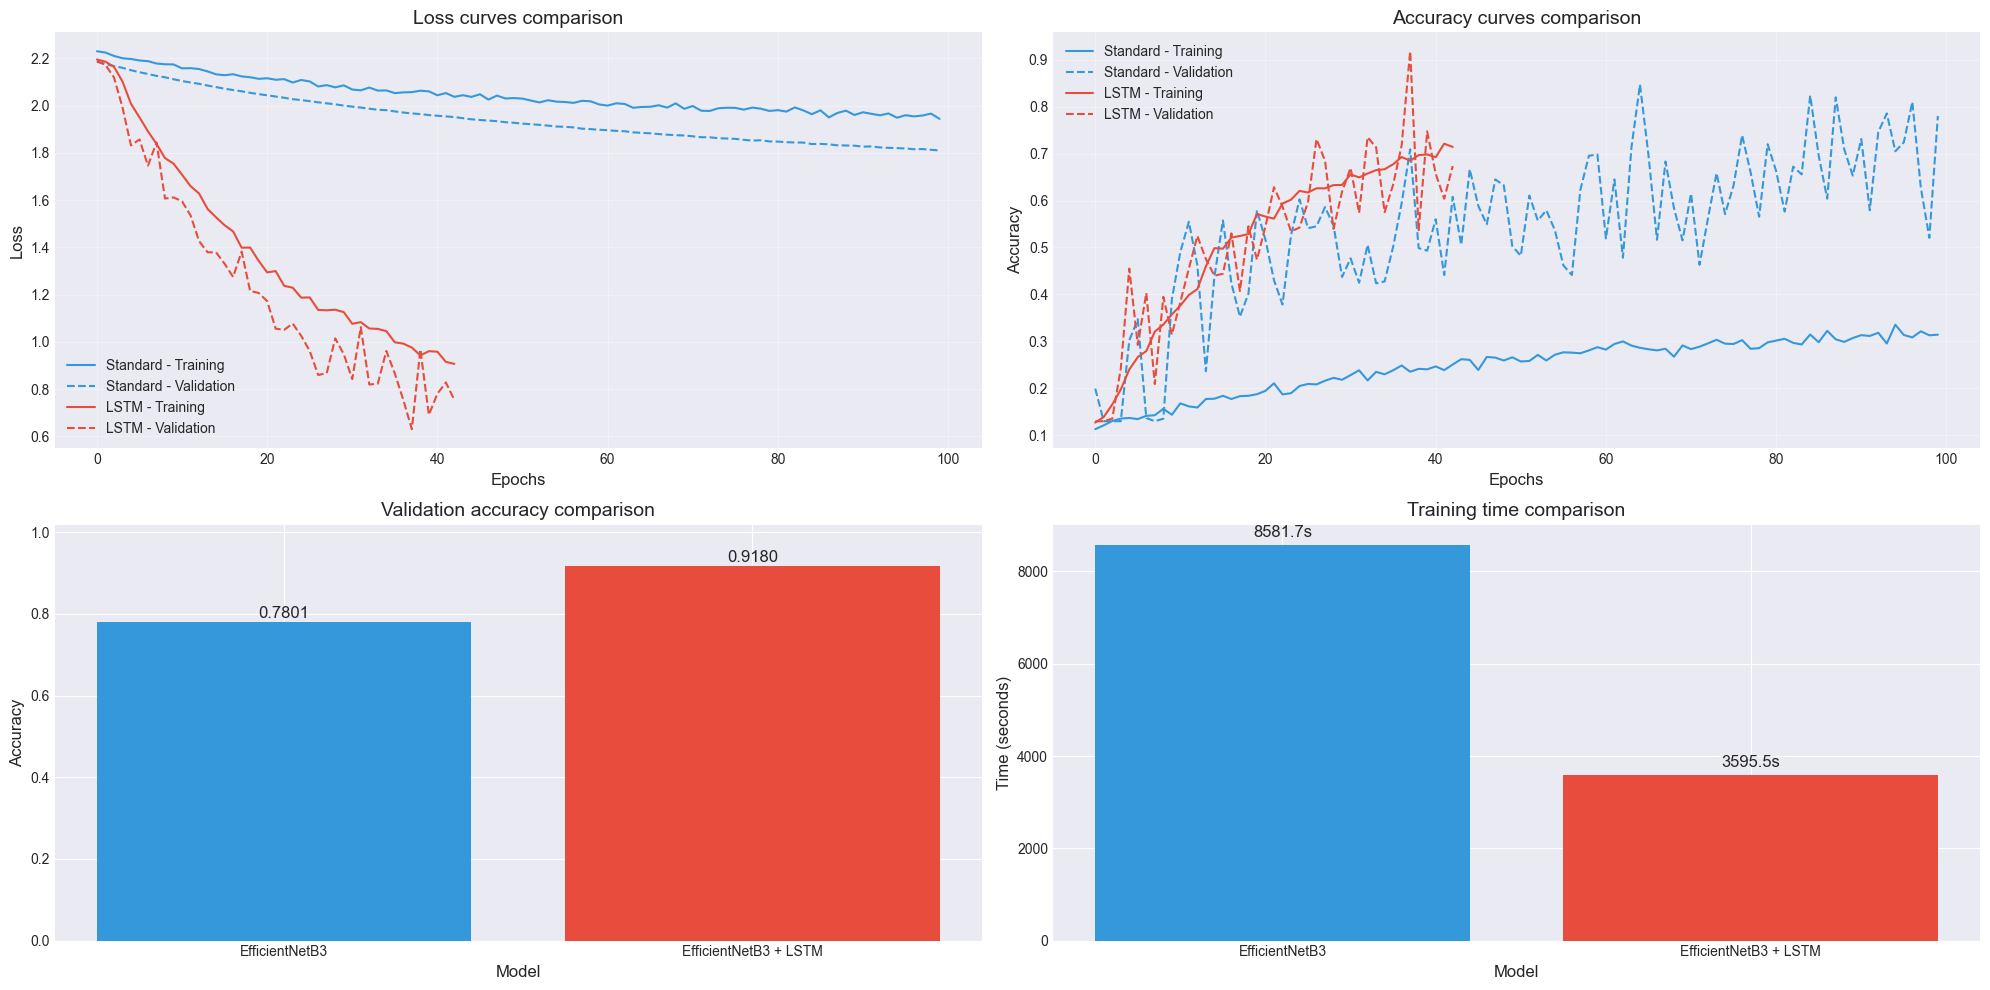

23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 637ms/step


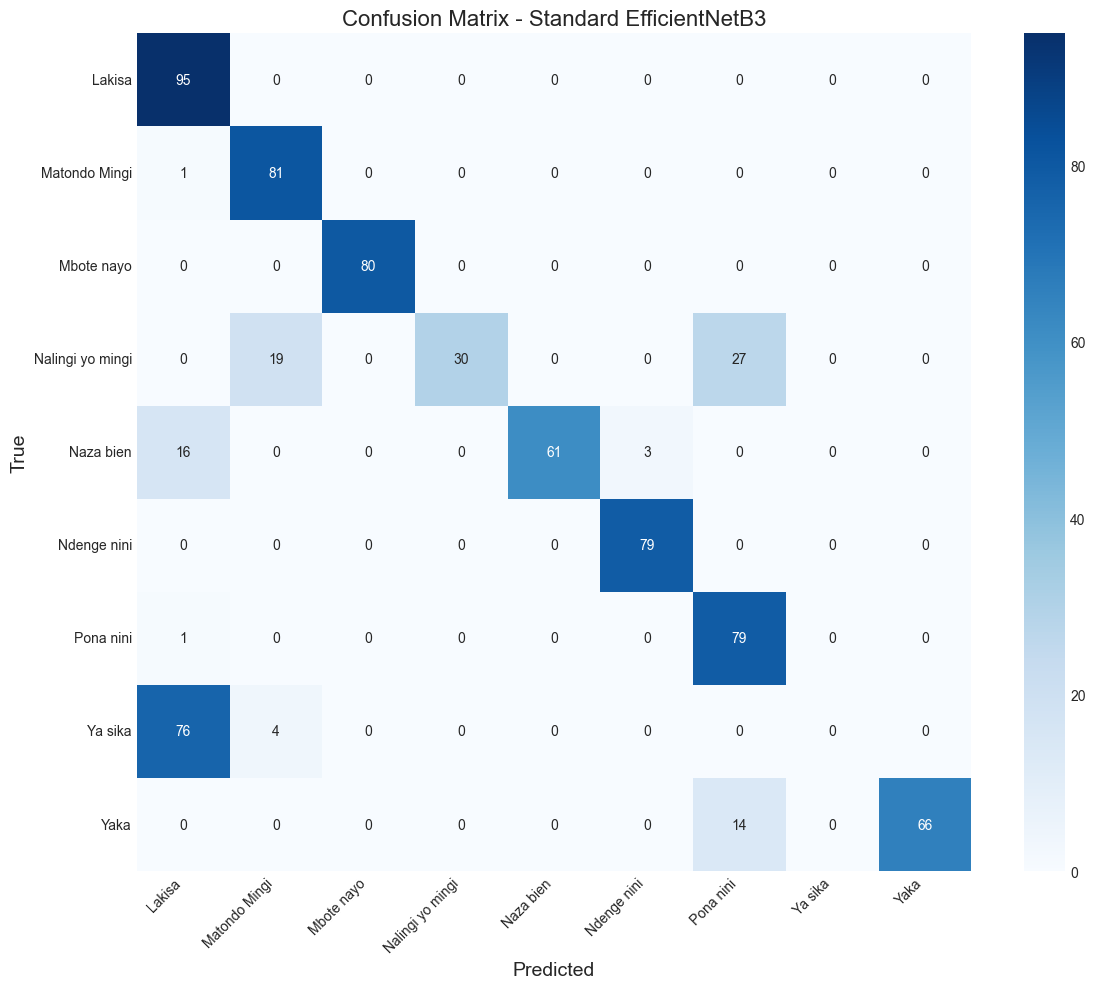


Classification report for Confusion Matrix - Standard EfficientNetB3:
                  precision    recall  f1-score   support

          Lakisa       0.50      1.00      0.67        95
   Matondo Mingi       0.78      0.99      0.87        82
      Mbote nayo       1.00      1.00      1.00        80
Nalingi yo mingi       1.00      0.39      0.57        76
       Naza bien       1.00      0.76      0.87        80
     Ndenge nini       0.96      1.00      0.98        79
       Pona nini       0.66      0.99      0.79        80
         Ya sika       0.00      0.00      0.00        80
            Yaka       1.00      0.82      0.90        80

        accuracy                           0.78       732
       macro avg       0.77      0.77      0.74       732
    weighted avg       0.76      0.78      0.74       732



d:\projets\envp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projets\envp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\projets\envp\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 638ms/step


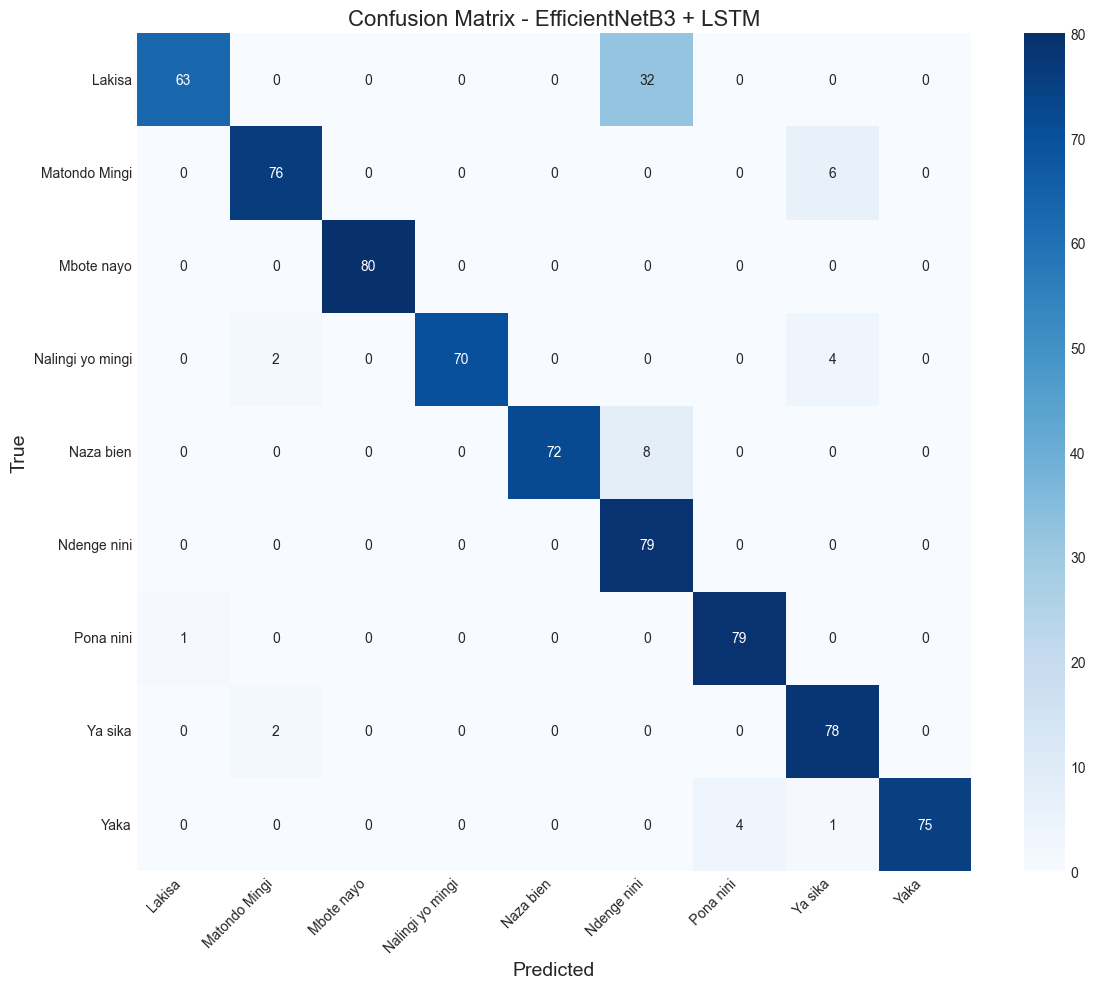


Classification report for Confusion Matrix - EfficientNetB3 + LSTM:
                  precision    recall  f1-score   support

          Lakisa       0.98      0.66      0.79        95
   Matondo Mingi       0.95      0.93      0.94        82
      Mbote nayo       1.00      1.00      1.00        80
Nalingi yo mingi       1.00      0.92      0.96        76
       Naza bien       1.00      0.90      0.95        80
     Ndenge nini       0.66      1.00      0.80        79
       Pona nini       0.95      0.99      0.97        80
         Ya sika       0.88      0.97      0.92        80
            Yaka       1.00      0.94      0.97        80

        accuracy                           0.92       732
       macro avg       0.94      0.92      0.92       732
    weighted avg       0.94      0.92      0.92       732


===== RESULTS SUMMARY =====
Metric                    EfficientNetB3       EfficientNetB3 + LSTM Difference     
------------------------------------------------------------

In [6]:
# Install required libraries (run once)
# !pip install tensorflow matplotlib numpy scikit-learn seaborn

# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, LSTM, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch


# Configure device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configure plot style
plt.style.use('seaborn-v0_8-darkgrid')
colors = {
    'model1': '#3498db',  # Blue for standard model
    'model2': '#e74c3c'   # Red for LSTM model
}

# === Data Loading Section === 
print("Loading data...")
data_path = r'D:\projets\Data_TeachSign'  # Raw string for Windows path

try:
    # Verify folder exists
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Folder not found: {data_path}")
    
    # Verify all required files exist
    required_files = ['X_train.npy', 'y_train.npy', 
                     'X_val.npy', 'y_val.npy', 
                     'labels.npy']
    
    missing_files = [f for f in required_files 
                   if not os.path.exists(os.path.join(data_path, f))]
    
    if missing_files:
        raise FileNotFoundError(f"Missing files: {missing_files}")
    
    # Load all files
    X_train = np.load(os.path.join(data_path, 'X_train.npy'))
    y_train = np.load(os.path.join(data_path, 'y_train.npy')) 
    X_val = np.load(os.path.join(data_path, 'X_val.npy'))
    y_val = np.load(os.path.join(data_path, 'y_val.npy'))
    label_classes = np.load(os.path.join(data_path, 'labels.npy'))

    # Define input shape and number of classes from loaded data
    input_shape = X_train.shape[1:]  # Extracts (224, 224, 3)
    num_classes = len(label_classes)
    
    # Success message
    print(f"SUCCESS: Loaded data from {data_path}")
    print(f"X_train shape: {X_train.shape}")
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {label_classes}")

except Exception as e:
    print("\nERROR LOADING DATA:")
    print(str(e))
    
    # Diagnostic information
    print("\nFOLDER CONTENTS:")
    if os.path.exists(data_path):
        for i, f in enumerate(os.listdir(data_path)):
            print(f"{i+1}. {f}")
    else:
        print(f"Folder does not exist: {data_path}")
    
    # Suggested fixes
    print("\nPOSSIBLE SOLUTIONS:")
    print("1. Verify the path is correct:")
    print(f"   Current path: {os.path.abspath(data_path)}")
    print("2. Check all required files exist in the folder")
    print("3. Try copying the folder to:")
    print(f"   {os.path.join(os.getcwd(), 'Data_TeachSign')}")
    
    raise SystemExit("Cannot continue without data")

# Training parameters configuration
batch_size = 32
epochs = 100
learning_rate = 0.0001

# Function to create standard EfficientNetB3 model
def create_standard_model():
    """Create standard EfficientNetB3 model with frozen base"""
    base_model = EfficientNetB3(weights='imagenet', 
                              include_top=False, 
                              input_shape=input_shape)
    base_model.trainable = False  # Freeze base layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Function to create EfficientNetB3 + LSTM model
def create_lstm_model():
    """Create hybrid EfficientNetB3 + LSTM model"""
    base_model = EfficientNetB3(weights='imagenet',
                              include_top=False,
                              input_shape=input_shape)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add temporal dimension for LSTM (treat as sequence of 1)
    x = Reshape((1, -1))(x)
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(128)(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# === Train standard EfficientNetB3 model ===
print("\n=== Model 1: Standard EfficientNetB3 ===")
model1 = create_standard_model()
model1.summary()

checkpoint_path1 = os.path.join(data_path, 'efficientnetb3_standard_best_model.h5')
callbacks1 = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path1, 
                  save_best_only=True, 
                  monitor='val_accuracy', 
                  mode='max')
]

start_time1 = time.time()
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks1
)
training_time1 = time.time() - start_time1

print(f"Standard model training time: {training_time1:.2f} seconds")
model1.save(os.path.join(data_path, 'efficientnetb3_standard_final_model.h5'))

# === Train EfficientNetB3 + LSTM model ===
print("\n=== Model 2: EfficientNetB3 + LSTM ===")
model2 = create_lstm_model()
model2.summary()

checkpoint_path2 = os.path.join(data_path, 'efficientnetb3_lstm_best_model.h5')
callbacks2 = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path2,
                  save_best_only=True,
                  monitor='val_accuracy',
                  mode='max')
]

start_time2 = time.time()
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks2
)
training_time2 = time.time() - start_time2

print(f"LSTM model training time: {training_time2:.2f} seconds")
model2.save(os.path.join(data_path, 'efficientnetb3_lstm_final_model.h5'))

# === Performance comparison ===
print("\n=== Model evaluation ===")
val_loss1, val_acc1 = model1.evaluate(X_val, y_val, verbose=0)
val_loss2, val_acc2 = model2.evaluate(X_val, y_val, verbose=0)

print(f"Standard EfficientNetB3 Model:")
print(f"  - Validation accuracy: {val_acc1:.4f}")
print(f"  - Validation loss: {val_loss1:.4f}")
print(f"  - Training time: {training_time1:.2f} seconds")

print(f"\nEfficientNetB3 + LSTM Model:")
print(f"  - Validation accuracy: {val_acc2:.4f}")
print(f"  - Validation loss: {val_loss2:.4f}")
print(f"  - Training time: {training_time2:.2f} seconds")

# Relative improvement in percentage
acc_improvement = ((val_acc2 - val_acc1) / val_acc1) * 100
print(f"\nRelative accuracy improvement with LSTM: {acc_improvement:.2f}%")

# === Comparison plots ===
plt.figure(figsize=(20, 10))

# Loss curve
plt.subplot(2, 2, 1)
plt.plot(history1.history['loss'], color=colors['model1'], linestyle='-', label='Standard - Training')
plt.plot(history1.history['val_loss'], color=colors['model1'], linestyle='--', label='Standard - Validation')
plt.plot(history2.history['loss'], color=colors['model2'], linestyle='-', label='LSTM - Training')
plt.plot(history2.history['val_loss'], color=colors['model2'], linestyle='--', label='LSTM - Validation')
plt.title('Loss curves comparison', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Accuracy curve
plt.subplot(2, 2, 2)
plt.plot(history1.history['accuracy'], color=colors['model1'], linestyle='-', label='Standard - Training')
plt.plot(history1.history['val_accuracy'], color=colors['model1'], linestyle='--', label='Standard - Validation')
plt.plot(history2.history['accuracy'], color=colors['model2'], linestyle='-', label='LSTM - Training')
plt.plot(history2.history['val_accuracy'], color=colors['model2'], linestyle='--', label='LSTM - Validation')
plt.title('Accuracy curves comparison', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Final accuracy (bar plot)
plt.subplot(2, 2, 3)
models = ['EfficientNetB3', 'EfficientNetB3 + LSTM']
accuracies = [val_acc1, val_acc2]
plt.bar(models, accuracies, color=[colors['model1'], colors['model2']])
plt.title('Validation accuracy comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=12)
plt.ylim(0, max(accuracies) + 0.1)

# Training time (bar plot)
plt.subplot(2, 2, 4)
times = [training_time1, training_time2]
plt.bar(models, times, color=[colors['model1'], colors['model2']])
plt.title('Training time comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
for i, v in enumerate(times):
    plt.text(i, v + max(times)*0.02, f'{v:.1f}s', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(data_path, 'model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# === Confusion matrices ===
def plot_confusion_matrix(model, X, y, title, save_path=None):
    """Generate and plot confusion matrix"""
    y_pred = np.argmax(model.predict(X), axis=1)
    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=label_classes,
               yticklabels=label_classes)
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    print(f"\nClassification report for {title}:")
    print(classification_report(y, y_pred, target_names=label_classes))

# Plot confusion matrices
plot_confusion_matrix(model1, X_val, y_val,
                    "Confusion Matrix - Standard EfficientNetB3",
                    os.path.join(data_path, 'confusion_standard.png'))

plot_confusion_matrix(model2, X_val, y_val,
                    "Confusion Matrix - EfficientNetB3 + LSTM",
                    os.path.join(data_path, 'confusion_lstm.png'))

# === Results summary ===
print("\n===== RESULTS SUMMARY =====")
print(f"{'Metric':<25} {'EfficientNetB3':<20} {'EfficientNetB3 + LSTM':<20} {'Difference':<15}")
print("-" * 80)
print(f"{'Validation accuracy':<25} {val_acc1:.4f}{'':<15} {val_acc2:.4f}{'':<15} {val_acc2-val_acc1:+.4f}")
print(f"{'Validation loss':<25} {val_loss1:.4f}{'':<15} {val_loss2:.4f}{'':<15} {val_loss2-val_loss1:+.4f}")
print(f"{'Training time (s)':<25} {training_time1:.2f}{'':<15} {training_time2:.2f}{'':<15} {training_time2-training_time1:+.2f}")
print(f"{'Relative improvement':<25} {'N/A':<20} {acc_improvement:+.2f}%{'':<12}")
print("-" * 80)

# Detect best model
best_model = "EfficientNetB3 + LSTM" if val_acc2 > val_acc1 else "Standard EfficientNetB3"
print(f"\nBest model: {best_model}")

# Conclusion
print("\nCONCLUSION:")
if val_acc2 > val_acc1:
    print(f"Adding LSTM layers improved accuracy by {acc_improvement:.2f}%, " +
         f"with validation accuracy of {val_acc2:.4f} vs {val_acc1:.4f} for the standard model.")
    if training_time2 > training_time1:
        print(f"However, this improvement comes with a training time increase " +
             f"of {training_time2-training_time1:.2f} seconds ({(training_time2/training_time1-1)*100:.1f}% longer).")
else:
    print(f"The standard EfficientNetB3 model performed better with an accuracy of " +
         f"{val_acc1:.4f} vs {val_acc2:.4f} for the LSTM model.")
    print(f"Moreover, the standard model is faster to train by {abs(training_time2-training_time1):.2f} seconds.")

print("\nRecommendation for the Lingala Sign Language Translation System:")
if val_acc2 > val_acc1 and (training_time2 - training_time1) / training_time1 < 0.5:
    print("Use the EfficientNetB3 + LSTM model for better accuracy with a reasonable trade-off on training time.")
elif val_acc2 > val_acc1:
    print("Evaluate the trade-off between the LSTM model's increased accuracy and its longer training time.")
else:
    print("Prefer the standard EfficientNetB3 model for its good balance between accuracy and training efficiency.")